# Evaluating hyperparameter tuning for STalign LDDMM modified function with gene expression for MERFISH data. 

Align two single-cell spatial MERFISH brain sections using LDDMM with cell density AND gene exp for select genes and all. 
#### Version: Using manually selected landmark points. 
(Using initial affine transformation of the image. )

Data source: Vizgen Data Release V1.0. May 2021 (https://info.vizgen.com/mouse-brain-map?submissionGuid=955163f1-3119-42d9-bcbf-e0255e6e7d17) 

Dataset used: Slice 2 Replicate 2, Slice 2 Replicate 3 

Code: Iris Kwon (skwon38@jh.edu)


# Import dependencies

In [18]:
!pip install scanpy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\caleb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [19]:
#import STalign
#from STalign import STalign
#dir(STalign)
import os
import matplotlib.pyplot as plt
##### %%time
import torch
import copy
from torch.nn.functional import grid_sample
import pandas as pd
import scanpy as sc
import numpy as np

In [20]:
import STalign

In [21]:
dir(STalign)
from STalign import STalign

In [22]:
dir(STalign)


['LDDMM',
 'LDDMM_3D_to_slice',
 'L_T_from_points',
 'Line2D',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'analyze3Dalign',
 'build_transform',
 'build_transform3D',
 'calculate_tre',
 'clip',
 'cm',
 'copy',
 'defaultdict',
 'download_aba_image_labels',
 'download_aba_ontology',
 'exists',
 'extent_from_x',
 'glob',
 'go',
 'grid_sample',
 'interp',
 'interp3D',
 'join',
 'make_scree',
 'makedirs',
 'normalize',
 'np',
 'nrrd',
 'os',
 'pd',
 'plot_brain_regions',
 'plot_subset_brain_regions',
 'plt',
 'px',
 'rasterize',
 'rasterizePCA',
 'rasterize_with_signal',
 'requests',
 'saveRasters',
 'split',
 'splitext',
 'sys',
 'to_A',
 'to_A_3D',
 'torch',
 'tornado',
 'transform_image_source_to_target',
 'transform_image_source_with_A',
 'transform_image_target_to_source',
 'transform_points_source_to_target',
 'transform_points_target_to_source',
 'v_to_phii',
 'v_to_phii_3D']

Run code below to check that matplotlib widget is working: 

In [23]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(np.random.rand(10))
plt.show()

RuntimeError: 'widget' is not a recognised GUI loop or backend name

In [ ]:
# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

# Functions

### Import select original functions from STalign.py 

In [ ]:
def normalize(arr, t_min=0, t_max=1):
    """Linearly normalizes an array between two specifed values.
    
    Parameters
    ----------
    arr : numpy array
        array to be normalized
    t_min : int or float
        Lower bound of normalization range
    t_max : int or float
        Upper bound of normalization range
    
    Returns
    -------
    norm_arr : numpy array
        1D array with normalized arr values
        
    """
    
    diff = t_max - t_min
    diff_arr = np.max(arr) - np.min(arr)
    min_ = np.min(arr)
    if diff_arr != 0:
        norm_arr = ((arr - min_)/diff_arr * diff) + t_min
    else:
        norm_arr = np.zeros(arr.shape)
    
    return norm_arr


def rasterize(x, y, g=np.ones(1), dx=15, blur=1.5, expand=1.2, draw=0, wavelet_magnitude=False,use_windowing=True):
    ''' Rasterize a spatial transcriptomics dataset into a density image
    
    Paramters
    ---------
    x : numpy array of length N
        x location of cells
    y : numpy array of length N
        y location of cells
    g : numpy array of length N
        RNA count of cells
        If not given, density image is created
    dx : float
        Pixel size to rasterize data (default 30.0, in same units as x and y)
    blur : float or list of floats
        Standard deviation of Gaussian interpolation kernel.  Units are in 
        number of pixels.  Can be aUse a list to do multi scale.
    expand : float
        Factor to expand sampled area beyond cells. Defaults to 1.1.
    draw : int
        If True, draw a figure every draw points return its handle. Defaults to False (0).
    wavelet_magnitude : bool
        If True, take the absolute value of difference between scales for raster images.
        When using this option blur should be sorted from greatest to least.
    
        
    Returns
    -------
    X  : numpy array
        Locations of pixels along the x axis
    Y  : numpy array
        Locations of pixels along the y axis
    M : numpy array
        A rasterized image with len(blur) channels along the first axis
    fig : matplotlib figure handle
        If draw=True, returns a figure handle to the drawn figure.
        
    Raises
    ------    
    Exception 
        If wavelet_magnitude is set to true but blur is not sorted from greatest to least.
        
        
    
    Examples
    --------
    Rasterize a dataset at 30 micron pixel size, with three kernels.
    
    >>> X,Y,M,fig = tools.rasterize(x,y,dx=30.0,blur=[2.0,1.0,0.5],draw=10000)
    
    Rasterize a dataset at 30 micron pixel size, with three kernels, using difference between scales.
    
    >>> X,Y,M,fig = tools.rasterize(x,y,dx=30.0,blur=[2.0,1.0,0.5],draw=10000, wavelet_magnitude=True)
        
        
    '''
    
    # set blur to a list
    if not isinstance(blur,list):
        blur = [blur]
    nb = len(blur)
    blur = np.array(blur)
    n = len(x)
    maxblur = np.max(blur) # for windowing
    
    
    
    if wavelet_magnitude and np.any(blur != np.sort(blur)[::-1]):
        raise Exception('When using wavelet magnitude, blurs must be sorted from greatest to least')
    
    minx = np.min(x)
    maxx = np.max(x)
    miny = np.min(y)
    maxy = np.max(y)
    minx,maxx = (minx+maxx)/2.0 - (maxx-minx)/2.0*expand, (minx+maxx)/2.0 + (maxx-minx)/2.0*expand
    miny,maxy = (miny+maxy)/2.0 - (maxy-miny)/2.0*expand, (miny+maxy)/2.0 + (maxy-miny)/2.0*expand
    X_ = np.arange(minx,maxx,dx)
    Y_ = np.arange(miny,maxy,dx)
    
    X = np.stack(np.meshgrid(X_,Y_)) # note this is xy order, not row col order

    W = np.zeros((X.shape[1],X.shape[2],nb))

    
    if draw: fig,ax = plt.subplots()
    count = 0
    
    g = np.resize(g,x.size)
    if(not (g==1.0).all()):
        g = normalize(g)
    #if np.sum(g) == 0:
    #    print('no gene exp')
    #    return X,Y,W, None
    for x_,y_,g_ in zip(x,y,g):
        # to speed things up I should index
        # to do this I'd have to find row and column indices
        #col = np.round((x_ - X_[0])/dx).astype(int)
        #row = np.round((y_ - X_[1])/dx).astype(int)
        #row0 = np.floor(row-blur*3).astype(int)
        #row1 = np.ceil(row+blur*3).astype(int)        
        #rows = np.arange(row0,row1+1)
        

        # this is incrementing one pixel at a time, it is way way faster, 
        # but doesn't use a kernel
        # I[c_,row,col] += 1.0
        # W[row,col] += 1.0
        if not use_windowing: # legacy version
            k = np.exp( - ( (X[0][...,None] - x_)**2 + (X[1][...,None] - y_)**2 )/(2.0*(dx*blur*2)**2)  )
            if np.sum(k,axis=(0,1)) != 0:
                k /= np.sum(k,axis=(0,1),keepdims=True)    
            k *= g_
            if wavelet_magnitude:
                for i in reversed(range(nb)):
                    if i == 0:
                        continue
                    k[...,i] = k[...,i] - k[...,i-1]

            W += k
        else: # use a small window
            r = int(np.ceil(maxblur*4))
            col = np.round((x_ - X_[0])/dx).astype(int)
            row = np.round((y_ - Y_[0])/dx).astype(int)
            
            row0 = np.floor(row-r).astype(int)
            row1 = np.ceil(row+r).astype(int)                    
            col0 = np.floor(col-r).astype(int)
            col1 = np.ceil(col+r).astype(int)
            
            # we need boundary conditions
            row0 = np.minimum(np.maximum(row0,0),W.shape[0]-1)
            row1 = np.minimum(np.maximum(row1,0),W.shape[0]-1)
            col0 = np.minimum(np.maximum(col0,0),W.shape[1]-1)
            col1 = np.minimum(np.maximum(col1,0),W.shape[1]-1)
            
           
            k =  np.exp( - ( (X[0][row0:row1+1,col0:col1+1,None] - x_)**2 + (X[1][row0:row1+1,col0:col1+1,None] - y_)**2 )/(2.0*(dx*blur*2)**2)  )
            if np.sum(k,axis=(0,1)) != 0:
                k /= np.sum(k,axis=(0,1),keepdims=True)  
            else:
                k=k
            k *= g_
            if wavelet_magnitude:
                for i in reversed(range(nb)):
                    if i == 0:
                        continue
                    k[...,i] = k[...,i] - k[...,i-1]
            W[row0:row1+1,col0:col1+1,:] += k #range of voxels -oka
            
        
            
        

        if draw:
            if not count%draw or count==(x.shape[0]-1):
                print(f'{count} of {x.shape[0]}')

                ax.cla()
                toshow = W-np.min(W,axis=(0,1),keepdims=True)
                toshow = toshow / np.max(toshow,axis=(0,1),keepdims=True)
                
                if nb >= 3:
                    toshow = toshow[...,:3]
                elif nb == 2:
                    toshow = toshow[...,[0,1,0]]
                elif nb == 1:
                    toshow = toshow[...,[0,0,0]]
                
                ax.imshow(np.abs(toshow))
                fig.canvas.draw()

        count += 1
    W = np.abs(W)
    # we will permute so channels are on first axis
    W = W.transpose((-1,0,1))
    extent = (X_[0],X_[-1],Y_[0],Y_[-1])
    
    # rename
    X = X_
    Y = Y_
    if draw:
        output = X,Y,W,fig
    else:
        output = X,Y,W
    return output

def L_T_from_points(pointsI,pointsJ):
    '''
    Compute an affine transformation from points.
    
    Note for an affine transformation (6dof) we need 3 points.
    
    Outputs, L,T should be rconstructed blockwize like [L,T;0,0,1]
    
    Parameters
    ----------
    pointsI : array
        An Nx2 array of floating point numbers describing source points in ROW COL order (not xy)
    pointsJ : array
        An Nx2 array of floating point numbers describing target points in ROW COL order (not xy)
    
    Returns
    -------
    L : array
        A 2x2 linear transform array.
    T : array
        A 2 element translation vector
    '''
    if pointsI is None or pointsJ is None:
        raise Exception('Points are set to None')
        
    nI = pointsI.shape[0]
    nJ = pointsJ.shape[0]
    if nI != nJ:
        raise Exception(f'Number of pointsI ({nI}) is not equal to number of pointsJ ({nJ})')
    if pointsI.shape[1] != 2:
        raise Exception(f'Number of components of pointsI ({pointsI.shape[1]}) should be 2')
    if pointsJ.shape[1] != 2:
        raise Exception(f'Number of components of pointsJ ({pointsJ.shape[1]}) should be 2')
    # transformation model
    if nI < 3:
        # translation only 
        L = np.eye(2)
        T = np.mean(pointsJ,0) - np.mean(pointsI,0)
    else:
        # we need an affine transform
        pointsI_ = np.concatenate((pointsI,np.ones((nI,1))),1)
        pointsJ_ = np.concatenate((pointsJ,np.ones((nI,1))),1)
        II = pointsI_.T@pointsI_
        IJ = pointsI_.T@pointsJ_
        A = (np.linalg.inv(II)@IJ).T        
        L = A[:2,:2]
        T = A[:2,-1]
    return L,T
    
import torch

def to_A(L,T):
    O = torch.tensor([0.,0.,1.],device=L.device,dtype=L.dtype)
    A = torch.cat((torch.cat((L,T[:,None]),1),O[None]))
    return A

def extent_from_x(xJ): #bounds for image to plot - ok
    dJ = [x[1]-x[0] for x in xJ] #step size between pixels along the axes - but is this difference between x and y?
    extentJ = ((xJ[1][0] - dJ[1]/2.0).item(),
               (xJ[1][-1] + dJ[1]/2.0).item(),
               (xJ[0][-1] + dJ[0]/2.0).item(),
               (xJ[0][0] - dJ[0]/2.0).item())
    
    return extentJ

def clip(I):

    Ic = torch.clone(I)
    Ic[Ic<0]=0
    Ic[Ic>1]=1
    return Ic

def interp(x,I,phii,**kwargs):
    # first we have to normalize phii to the range -1,1    
    I = torch.as_tensor(I)
    phii = torch.as_tensor(phii)
    phii = torch.clone(phii)
    for i in range(2):
        phii[i] -= x[i][0]
        phii[i] /= x[i][-1] - x[i][0]
    # note the above maps to 0,1
    phii *= 2.0
    # to 0 2
    phii -= 1.0
    # done

    # NOTE I should check that I can reproduce identity
    # note that phii must now store x,y,z along last axis
    # is this the right order?
    # I need to put batch (none) along first axis
    # what order do the other 3 need to be in?    
    out = grid_sample(I[None],phii.flip(0).permute((1,2,0))[None],align_corners=True,**kwargs)
    # note align corners true means square voxels with points at their centers
    # post processing, get rid of batch dimension

    return out[0]

### Added rasterizeByGene() function to rasterize for an n-dimensional cellxgene matrix, with n=number of genes we are considering for analysis: 

In [ ]:
def rasterizeByGene(x, y, G, dx=15, blur=1.5, expand=1.2, draw=10000, wavelet_magnitude=False,use_windowing=True):
    nrows=0
    ncols=0
    
    for i in range(G.shape[1]):
        g = np.array(G.iloc[:,i])
        
        XI,YI,I = rasterize(x,y,g=g,dx=dx,blur=blur,expand =expand)
        
        if(i==0):
            # dimensions
            nrows=YI.size
            ncols=XI.size
            X = np.empty([G.shape[1], nrows, ncols])
            Y = np.empty([G.shape[1], nrows*ncols])
        
        # centers data
        X[i] = np.array(I)
        I_ = I.ravel()
        meanI = np.mean(I_)
        I_ -= meanI
        Y[i] = I_
        
        if(i % 10 == 0):
            print(f"{i} out of {G.shape[1]} genes rasterized.")

    
    return X, Y, XI, YI

# Analysis:

In [ ]:
os.chdir('C:\KebschullLab1\common_butterwort\iris\Data') # windows path to where data is located on KebschullLab1 computer 

In [ ]:
# Load source data
df20 = pd.read_csv('C:\KebschullLab1\common_butterwort\iris\Data\datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv', index_col=0)
df21 = pd.read_csv('C:\KebschullLab1\common_butterwort\iris\Data\datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_by_gene_S2R3.csv', index_col=0)

#Load x position
xI= np.array(df20['center_x']) #change to x positions of cells
#Load y position
yI= np.array(df20['center_y']) #change to column y positions of cells


In [ ]:
# Load target data
df10 = pd.read_csv('C:\KebschullLab1\common_butterwort\iris\Data\datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_metadata_S2R2.csv', index_col=0)
df11 = pd.read_csv('C:\KebschullLab1\common_butterwort\iris\Data\datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_by_gene_S2R2.csv',index_col=0)
#Load x position
xJ= np.array(df10['center_x']) #change to x positions of cells
#Load y position
yJ = np.array(df10['center_y']) #change to column y positions of cells

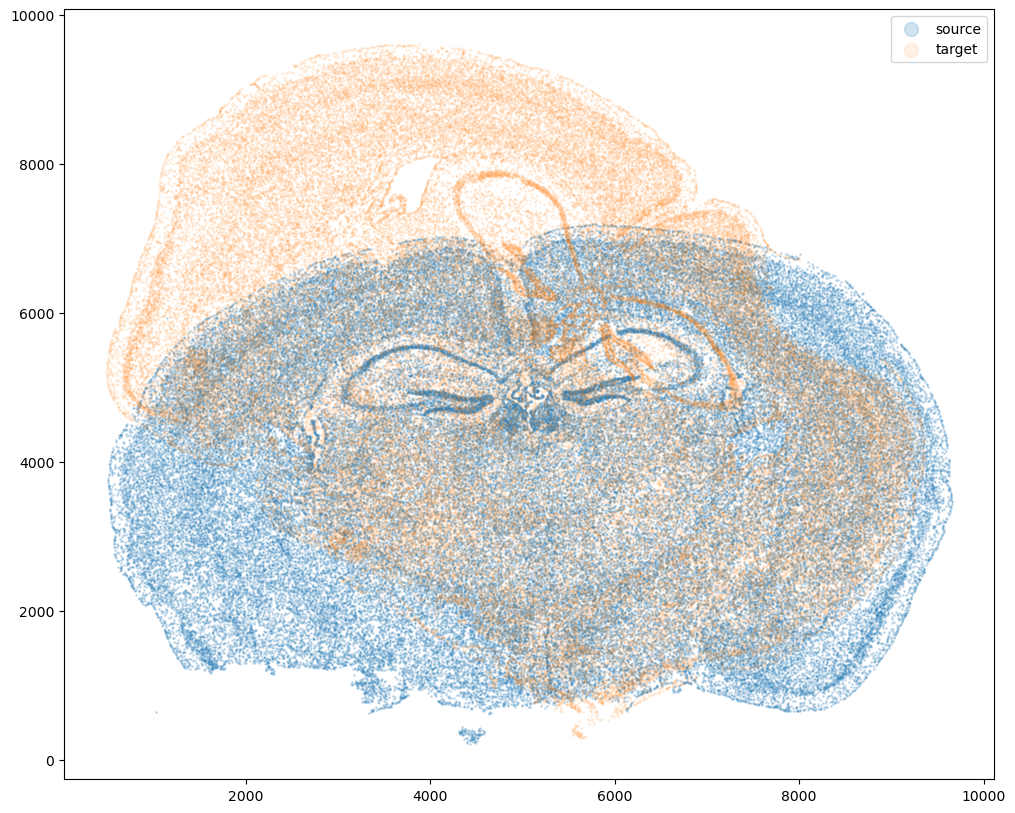

In [16]:
# plot both source and target data as images overlaid 
# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2, label='source')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label= 'target')
ax.legend(markerscale = 10)

In [26]:
import anndata as ad
# target anndata
data_r2 = ad.AnnData(np.array(df11))
data_r2.var_names = np.array(df11.columns)
data_r2.obs_names = df11.index
data_r2.obsm['spatial'] = np.array([[xJ[i], yJ[i]] for i in range(len(xJ))])

# source anndata
data_r3 = ad.AnnData(np.array(df21))
data_r3.var_names = np.array(df21.columns)
data_r3.obs_names = df21.index
data_r3.obsm['spatial'] = np.array([[xI[i], yI[i]] for i in range(len(xI))])

# until here 
df11 = target 
df22 = source

In [ ]:
data_r2.X

In [ ]:
import anndata as ad
data_r2 = ad.AnnData(np.array(df11))
data_r2.var_names = np.array(df11.columns)
data_r2.obs_names = df11.index
data_r2.obsm['spatial'] = np.array([[x1[i], y1[i]] for i in range(len(x1))])

data_r3 = ad.AnnData(np.array(df21))
data_r3.var_names = np.array(df21.columns)
data_r3.obs_names = df21.index
data_r3.obsm['spatial'] = np.array([[x2[i], y2[i]] for i in range(len(x2))])

In [ ]:
# Don't filter for now 
data_r2.X = data_r2.X.astype(np.float64)

sc.pp.normalize_total(data_r2, target_sum=1e4)
sc.pp.log1p(data_r2)


sc.pp.normalize_total(data_r3, target_sum=1e4)
sc.pp.log1p(data_r3)

#sc.pp.highly_variable_genes(data_sham)

data_r2.X = data_r2.X.astype(np.float64)
data_r3.X = data_r3.X.astype(np.float64)

sc.pp.highly_variable_genes(data_r2)
sc.pp.highly_variable_genes(data_r3)

genes_t22 = np.array(data_r3.var['highly_variable'][data_r3.var['highly_variable']==True][0:500].index.values)
genes_t12 = np.array(data_r2.var['highly_variable'][data_r2.var['highly_variable']==True][0:500].index.values)

genes_int = np.intersect1d(genes_t22, genes_t12)

df2 = pd.DataFrame(data_r3.X, columns=data_r3.var.index)
df1 = pd.DataFrame(data_r2.X, columns=data_r2.var.index)

indices2 = [index for index, value in enumerate(data_r3.var.index) if value in genes_int]
indices1 = [index for index, value in enumerate(data_r2.var.index) if value in genes_int]

df1 = df1.iloc[:,indices1]
df2 = df2.iloc[:,indices2]

G1 = df1.reindex(columns =df1.columns)
G2 = df2.reindex(columns =df1.columns)

x_1 = [data_r2.obsm['spatial'][:,0],data_r2.obsm['spatial'][:,1]]
x_2 = [data_r3.obsm['spatial'][:,0],data_r3.obsm['spatial'][:,1]]



In [ ]:
G1.shape

In [ ]:
Xg1, Y, XI, YI = rasterizeByGene(x_1[0], x_1[1], G1, dx=15, blur=1.5, expand=1.2, draw=10000, wavelet_magnitude=False,use_windowing=True)

In [ ]:
Xg2, Y, XJ, YJ = rasterizeByGene(x_2[0], x_2[1], G2, dx=15, blur=1.5, expand=1.2, draw=10000, wavelet_magnitude=False,use_windowing=True)

In [ ]:
X, Y, Xct1 = rasterize(x_1[0], x_1[1]) # Xct cell type density images 
X, Y, Xct2 = rasterize(x_2[0], x_2[1])

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(Xct1[0], vmax = 5)
ax[1].imshow(Xct2[0], vmax = 5)
plt.show()

In [ ]:
os.chdir('/Users/iriskwon/Library/CloudStorage/OneDrive-SharedLibraries-JohnsHopkins/Manjari Anant - Iris/stalign_gene_expression/STalign2')

In [ ]:
G1.columns

In [ ]:
#22 and 33,40, 42, 48 are good candidates

for i in range(len(Xg1)):
    if i==0: print("Printing rasterized source and target images...")
    print(i)
    print(G1.columns[i])
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(Xg1[i])
    ax[1].imshow(Xg2[i])
    plt.show()

In [ ]:
for i in [22,33,40,42]:
    print(i)
    print(G1.columns[i])
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(Xg1[i])
    ax[1].imshow(Xg2[i])
    plt.show()

In [ ]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Button, HBox, VBox, Label

# Normalize your gene expression images
img1 = (Xg1[0] - np.min(Xg1[0])) / (np.max(Xg1[0]) - np.min(Xg1[0]))
img2 = (Xg2[0] - np.min(Xg2[0])) / (np.max(Xg2[0]) - np.min(Xg2[0]))

# Convert to RGB for display (blue channel)
img1_rgb = np.zeros((img1.shape[0], img1.shape[1], 3))
img2_rgb = np.zeros((img2.shape[0], img2.shape[1], 3))
img1_rgb[:, :, 2] = img1 * 50   # scale if needed for visibility
img2_rgb[:, :, 2] = img2 * 50

# Create figure
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].set_title("Source Image")
ax[1].set_title("Target Image")

# Display images
im1_artist = ax[0].imshow(img1_rgb, vmin=0, vmax=10000)
im2_artist = ax[1].imshow(img2_rgb, vmin=0, vmax=10000)

# State dictionary
state = {
    'x1': None, 'y1': None,
    'x2': None, 'y2': None,
    'point': 0,
    'source_pts': [],
    'target_pts': []
}

# Label for instructions
label = Label(value="Click a landmark in the Source Image.")

# Click handler
def onclick(event):
    if event.inaxes == ax[0]:
        ix, iy = int(event.xdata), int(event.ydata)
        state['x1'], state['y1'] = ix, iy
        state['point'] = 1
        label.value = "Click the corresponding landmark in the Target Image."
        ax[0].scatter(ix, iy, c='r', s=30)
        fig.canvas.draw()
    elif event.inaxes == ax[1] and state['point'] == 1:
        ix, iy = int(event.xdata), int(event.ydata)
        state['x2'], state['y2'] = ix, iy
        state['point'] = 2
        label.value = "Press 'Record Landmark' to save this pair."
        ax[1].scatter(ix, iy, c='r', s=30)
        fig.canvas.draw()

# Record landmark button
def record_landmark(btn):
    if state['point'] == 2:
        state['source_pts'].append([state['x1'], state['y1']])
        state['target_pts'].append([state['x2'], state['y2']])
        state['point'] = 0
        label.value = "Click a landmark in the Source Image."
        print("Recorded points:")
        print("Source:", state['source_pts'])
        print("Target:", state['target_pts'])

# Done button
def done_selection(btn):
    label.value = f"Landmark selection finished. Total points: {len(state['source_pts'])}"
    print("Final Source Points:", state['source_pts'])
    print("Final Target Points:", state['target_pts'])
    fig.canvas.mpl_disconnect(cid)

# Create buttons
record_btn = Button(description="Record Landmark")
done_btn = Button(description="Done")
record_btn.on_click(record_landmark)
done_btn.on_click(done_selection)

# Connect click event
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Display buttons
display(VBox([label, HBox([record_btn, done_btn])]))

plt.show()

In [ ]:
source_pts = state['source_pts']
target_pts = state['target_pts']
# source_points = np.array(source_points)
# target_points = np.array(target_points)

In [ ]:
source_pts, target_pts

In [ ]:
import STalign

In [ ]:
dir(STalign)

In [ ]:
#import STalign 
pointsI = np.zeros([len(source_pts),2])
pointsJ = np.zeros([len(source_pts),2])

# np.max(np.array(source_pts)[:,0])-
pointsI[:,1] = np.array(XI[np.array(source_pts)[:,0]])
pointsI[:,0] = np.array(YI[np.array(source_pts)[:,1]])
pointsJ[:,1] = np.array(XJ[np.array(target_pts)[:,0]])
pointsJ[:,0] = np.array(YJ[np.array(target_pts)[:,1]])

L,T = L_T_from_points(pointsJ,pointsI)
A = to_A(torch.tensor(L),torch.tensor(T))

Xct1 = (Xct1 - np.min(Xct1))/(np.max(Xct1)-np.min(Xct1))
Xct2 = (Xct2 - np.min(Xct2))/(np.max(Xct2)-np.min(Xct2))

Xg1 = (Xg1 - np.min(Xg1))/(np.max(Xg1)-np.min(Xg1))
Xg2 = (Xg2 - np.min(Xg2))/(np.max(Xg2)-np.min(Xg2))

In [ ]:
Xct1 = (Xct1 - np.min(Xct1))/(np.max(Xct1)-np.min(Xct1))
Xct2 = (Xct2 - np.min(Xct2))/(np.max(Xct2)-np.min(Xct2))

Xg1 = (Xg1 - np.min(Xg1))/(np.max(Xg1)-np.min(Xg1))
Xg2 = (Xg2 - np.min(Xg2))/(np.max(Xg2)-np.min(Xg2))

In [ ]:
def LDDMM(xI,I,xJ,J,Ig, Jg, pointsI=None,pointsJ=None,
          L=None,T=None,A=None,v=None,xv=None,
          a=500.0,p=2.0,expand=2.0,nt=3,
         niter=5000,diffeo_start=0, epL=2e-8, epT=2e-1, epV=2e3,
         sigmaM=1.0,sigmaMg=1.0, sigmaB=2.0,sigmaA=5.0,sigmaR=5e5,sigmaP=2e1,
          device='cpu',dtype=torch.float64, muB=None, muA=None):
 
    if A is not None:
        # if we specify an A
        if L is not None or T is not None:
            raise Exception('If specifying A, you must not specify L or T')
        L = torch.tensor(A[:2,:2],device=device,dtype=dtype,requires_grad=True)
        T = torch.tensor(A[:2,-1],device=device,dtype=dtype,requires_grad=True)   
    else:
        # if we do not specify A                
        if L is None: L = torch.eye(2,device=device,dtype=dtype,requires_grad=True)
        if T is None: T = torch.zeros(2,device=device,dtype=dtype,requires_grad=True)
    L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
    T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
    # change to torch
    I = torch.tensor(I,device=device,dtype=dtype)                         
    J = torch.tensor(J,device=device,dtype=dtype)
    Jg = torch.tensor(Jg,device=device,dtype=dtype)
    if v is not None and xv is not None:
        v = torch.tensor(v,device=device,dtype=dtype,requires_grad=True)
        xv = [torch.tensor(x,device=device,dtype=dtype) for x in xv]
        XV = torch.stack(torch.meshgrid(xv),-1)
        nt = v.shape[0]        
    elif v is None and xv is None:
        minv = torch.as_tensor([x[0] for x in xI],device=device,dtype=dtype)
        maxv = torch.as_tensor([x[-1] for x in xI],device=device,dtype=dtype)
        minv,maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0],device=device,dtype=dtype)[...,None]*(maxv-minv)*expand # WHY DO IT THIS WAY??
        xv = [torch.arange(m,M,a*0.5,device=device,dtype=dtype) for m,M in zip(minv,maxv)] # "a" determines step size of velocity field
        XV = torch.stack(torch.meshgrid(xv),-1) #creating a meshgrid to apply transformation to all points in a grid (creating the 'field' in velocity field)
        v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2]),device=device,dtype=dtype,requires_grad=True) # why does XW have a shape of 3 (aren't there only x and y points? 2D)
        #velocity field start out as a zero vector field - how does it get updated? 
    else:
        raise Exception(f'If inputting an initial v, must input both xv and v')
    extentV = extent_from_x(xv) #for plotting purposes
    dv = torch.as_tensor([x[1]-x[0] for x in xv],device=device,dtype=dtype) #step in between each set of points
    
    
 
    fv = [torch.arange(n,device=device,dtype=dtype)/n/d for n,d in zip(XV.shape,dv)] # 5 dimensions of grid of XV/dv - should be similar to XV but not a meshgrid, just points along each axis
    extentF = extent_from_x(fv) #plotting
    FV = torch.stack(torch.meshgrid(fv),-1) # would this not just be the same as XV? print out both and compare 
    LL = (1.0 + 2.0*a**2* torch.sum( (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0) #smoothing kernel? what is this?

    K = 1.0/LL
    #fig,ax = plt.subplots()
    #ax.imshow(K,vmin=0.0,vmax=0.1,extent=extentF)
    
    #fig,ax = plt.subplots()
    #ax.imshow(K[0].cpu())
    DV = torch.prod(dv)
    Ki = torch.fft.ifftn(K).real
    fig,ax = plt.subplots()
    ax.imshow(Ki.clone().detach().cpu().numpy(),vmin=0.0,extent=extentV)
    ax.set_title('smoothing kernel')
    fig.canvas.draw()


    # nt = 3
    


    WM = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.5
    WB = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.4
    WA = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.1
    if pointsI is None and pointsJ is None:
        pointsI = torch.zeros((0,2),device=J.device,dtype=J.dtype)
        pointsJ = torch.zeros((0,2),device=J.device,dtype=J.dtype) 
    elif (pointsI is None and pointsJ is not None) or (pointsJ is None and pointsI is not None):
        raise Exception('Must specify corresponding sets of points or none at all')
    else:
        pointsI = torch.tensor(pointsI,device=J.device,dtype=J.dtype)
        pointsJ = torch.tensor(pointsJ,device=J.device,dtype=J.dtype)
    
    
    xI = [torch.tensor(x,device=device,dtype=dtype) for x in xI]
    xJ = [torch.tensor(x,device=device,dtype=dtype) for x in xJ]
    XI = torch.stack(torch.meshgrid(*xI,indexing='ij'),-1)
    XJ = torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1)
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = (xJ[1][0].item()-dJ[1].item()/2.0,
          xJ[1][-1].item()+dJ[1].item()/2.0,
          xJ[0][-1].item()+dJ[0].item()/2.0,
          xJ[0][0].item()-dJ[0].item()/2.0)
    

    if muA is None:
        estimate_muA = True
    else:
        estimate_muA = False
    if muB is None:
        estimate_muB = True
    else:
        estimate_muB = False
    
    fig,ax = plt.subplots(2,3)
    ax = ax.ravel()
    figE,axE = plt.subplots(1,5)
    Esave = []

    try:
        L.grad.zero_()
    except:
        pass
    try:
        T.grad.zero_()
    except:
        pass


    
    for it in range(niter):
        # make A
        A = to_A(L,T)
        # Ai
        Ai = torch.linalg.inv(A)
        # transform sample points
        Xs = (Ai[:2,:2]@XJ[...,None])[...,0] + Ai[:2,-1]    
        # now diffeo, not semilagrange here
        for t in range(nt-1,-1,-1):
            Xs = Xs + interp(xv,-v[t].permute(2,0,1),Xs.permute(2,0,1)).permute(1,2,0)/nt
        # and points
        pointsIt = torch.clone(pointsI)
        if pointsIt.shape[0] >0:
            for t in range(nt):            
                pointsIt += interp(xv,v[t].permute(2,0,1),pointsIt.T[...,None])[...,0].T/nt
            pointsIt = (A[:2,:2]@pointsIt.T + A[:2,-1][...,None]).T
        #print(Xs.shape)
        # transform image
        #AI = interp(xI,I.swapaxes(1,2),Xs.permute(2,1,0),padding_mode="border")
        AI = interp(xI,I,Xs.permute(2,0,1),padding_mode="border")
        AIg = interp(xI,Ig,Xs.permute(2,0,1),padding_mode="border")
        #AI = AI.permute(0,2,1)
        #print(AI.shape)
        #print(J.shape)
        if it == 0:
            AI_orig = AIg.clone().detach()
        # objective function
        EMg = torch.sum((AIg - Jg)**2*WM)/2.0/sigmaMg**2
        
        EM = torch.sum((AI - J)**2*WM)/2.0/sigmaM**2
        ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
        E = EM + ER + EMg
        tosave = [E.item(), EM.item(), ER.item(), EMg.item()]
        if pointsIt.shape[0]>0:
            EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
            E += EP
            tosave.append(EP.item())
        
        Esave.append( tosave )
        # gradient update
        E.backward()
        with torch.no_grad():            
            L -= (epL/(1.0 + (it>=diffeo_start)*9))*L.grad
            T -= (epT/(1.0 + (it>=diffeo_start)*9))*T.grad

            L.grad.zero_()
            T.grad.zero_()
            

            # v grad
            vgrad = v.grad
            # smooth it
            vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad,dim=(1,2))*K[...,None],dim=(1,2)).real
            if it >= diffeo_start:
                v -= vgrad*epV
            v.grad.zero_()


        # update weights
        if not it%5:
            with torch.no_grad():
                # M step for these params
                if estimate_muA:
                    muA = torch.sum(WA*J,dim=(-1,-2))/torch.sum(WA)
                if estimate_muB:
                    muB = torch.sum(WB*J,dim=(-1,-2))/torch.sum(WB)
                #if it <= 200:
                #    muA = torch.tensor([0.75,0.77,0.79],device=J.device,dtype=J.dtype)
                #    muB = torch.ones(J.shape[0],device=J.device,dtype=J.dtype)*0.9




        # draw
        if not it%10:
            AI_plt = AIg
            J_plt = Jg
            #print(AI.shape)
            if AI.shape[0]>=1:
                AI_plt = torch.mean(AIg, 0)
                AI_plt = torch.unsqueeze(AI_plt, 0)
                AI_orig = torch.mean(AI_orig, 0)
                AI_orig = torch.unsqueeze(AI_orig, 0)
                J_plt = torch.mean(Jg, 0)
                J_plt = torch.unsqueeze(J_plt, 0)
            #print(AI_plt.shape)
            ax[0].cla()
            ax[0].imshow(   ((AI_orig-torch.amin(AI_orig,(1,2))[...,None,None])/(torch.amax(AI_orig,(1,2))-torch.amin(AI_orig,(1,2)))[...,None,None]).permute(1,2,0).clone().detach().cpu(),extent=extentJ)
            ax[0].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[0].set_title('space tformed source')
            
            ax[1].cla()
            ax[1].imshow(   ((AI_plt-torch.amin(AI_plt,(1,2))[...,None,None])/(torch.amax(AI_plt,(1,2))-torch.amin(AI_plt,(1,2)))[...,None,None]).permute(1,2,0).clone().detach().cpu(),extent=extentJ)
            ax[1].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[1].set_title('space tformed source')
            
            ax[4].cla()
            ax[4].imshow(clip( (AI_plt - J_plt)/(torch.max(Jg).item())*3.0  ).permute(1,2,0).clone().detach().cpu()*0.5+0.5,extent=extentJ)
            ax[4].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[4].scatter(pointsJ[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu())
            ax[4].set_title('Error')

            ax[2].cla()
            ax[2].imshow(J_plt.permute(1,2,0).cpu()/torch.max(Jg).item(),extent=extentJ)
            ax[2].scatter(pointsJ[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu())
            ax[2].set_title('Target')


            toshow = v[0].clone().detach().cpu()
            toshow /= torch.max(torch.abs(toshow))
            toshow = toshow*0.5+0.5
            toshow = torch.cat((toshow,torch.zeros_like(toshow[...,0][...,None])),-1)   
            ax[3].cla()
            ax[3].imshow(clip(toshow),extent=extentV)
            ax[3].set_title('velocity')
            
            # axE[0].cla()
            # axE[0].plot([e[0] for e in Esave])
            # axE[0].legend(['E'])
            # axE[0].set_yscale('log')
            # axE[1].cla()
            # axE[1].plot([e[1] for e in Esave])
            # axE[1].legend(['EM'])
            # axE[1].set_yscale('log')
            # axE[2].cla()
            # axE[2].plot([e[2] for e in Esave])
            # axE[2].legend(['ER'])
            # axE[2].set_yscale('log')
            # axE[3].cla()
            # axE[3].plot([e[3] for e in Esave])
            # axE[3].legend(['EMg'])
            # axE[3].set_yscale('log')
            # axE[4].cla()
            # axE[4].plot([e[4] for e in Esave])
            # axE[4].legend(['EP'])
            # axE[4].set_yscale('log')

            Esave_array = np.array(Esave)  # shape: (niter_done, n_components)

            # Compute per-iteration delta
            delta = np.diff(Esave_array, axis=0)  # shape: (niter_done-1, n_components)
            delta = np.vstack([np.zeros((1,Esave_array.shape[1])), delta])  # prepend 0 for first iteration
            
            labels = ['E', 'EM', 'ER', 'EMg', 'EP']
            
            for i in range(len(labels)):
                axE[i].cla()
                axE[i].plot([e[i] for e in Esave], label=f'{labels[i]}')
                axE[i].set_yscale('log')
                
                # Annotate the last delta on the plot
                axE[i].text(0.95, 0.95, f'Δ={delta[-1,i]:.3e}', 
                             transform=axE[i].transAxes,
                             horizontalalignment='right', verticalalignment='top',
                             fontsize=9, color='red')
                
                axE[i].legend([labels[i]])

            fig.canvas.draw()
            figE.canvas.draw()
            
    return {
        'A': A.clone().detach(), 
        'v': v.clone().detach(), 
        'xv': xv, 
        'WM': WM.clone().detach(),
        'WB': WB.clone().detach(),
        'WA': WA.clone().detach(),
        "AI_plt": AI_plt.clone().detach(), # plotting version 
        "AI": AI.clone().detach(), # the ST-aligned source image 
        "J": J.clone().detach(), 
        "pointsIt": pointsIt.clone().detach(), # final aligned points 
        "E": Esave
    }

/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/3834269516.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(A[:2,:2],device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/3834269516.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(A[:2,-1],device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/3834269516.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.ten

CPU times: user 6min 6s, sys: 3min 43s, total: 9min 49s
Wall time: 4min 33s


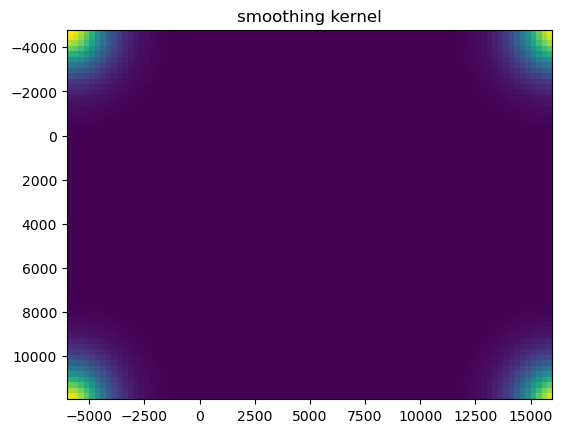

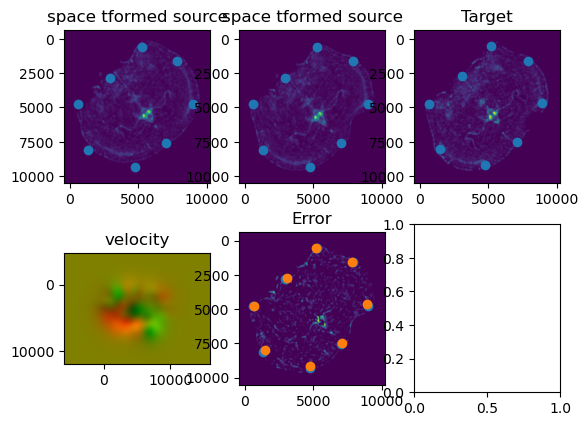

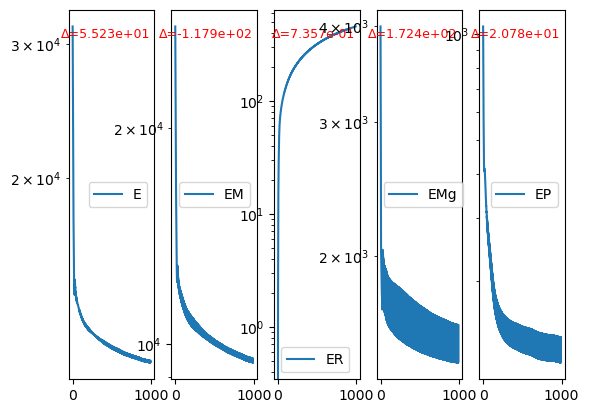

In [33]:
%%time
%matplotlib inline

params = {
    'niter': 1000,
    'a': 500,
    'pointsI': pointsJ,
    'pointsJ': pointsI,
    'sigmaM': 0.25,
    'sigmaMg': 0.25,
    'A': A,
}

# Selecting spatially distinct genes
out_cell_g = LDDMM(
    xI=[YJ, XJ], I=Xct2, 
    xJ=[YI, XI], J=Xct1,
    Ig=Xg2[[22,33,40,42,48], :, :],
    Jg=Xg1[[22,33,40,42,48], :, :],
    **params
)

### Testing LDDMM convergence across multiple parameters (sigmaM, sigmaMg, and a) and plotting the energy curves. 
Automatically tracks total energy and component energies per iteration and computes delta-E for convergence assessment. 

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Run LDDMM for multiple parameter combinations
def run_LDDMM_sweep(LDDMM_func, xI, I, xJ, J, Ig, Jg, pointsI=None, pointsJ=None,
                     sigmaM_list=[0.25, 0.5], sigmaMg_list=[0.25, 0.5], a_list=[200, 500],
                     niter=500, **kwargs):
    """
    Run LDDMM for all combinations of sigmaM, sigmaMg, and a.
    Returns a list of dictionaries with energy curves and parameters.
    """
    results = []

    for sigmaM in sigmaM_list:
        for sigmaMg in sigmaMg_list:
            for a_val in a_list:
                print(f"Running LDDMM with sigmaM={sigmaM}, sigmaMg={sigmaMg}, a={a_val}")
                
                out = LDDMM_func(
                    xI=xI,
                    I=I,
                    xJ=xJ,
                    J=J,
                    Ig=Ig,
                    Jg=Jg,
                    pointsI=pointsI,
                    pointsJ=pointsJ,
                    sigmaM=sigmaM,
                    sigmaMg=sigmaMg,
                    a=a_val,
                    niter=niter,
                    **kwargs
                )

                Esave = np.array(out.get('Esave', []))  # safer access
                if Esave.size == 0:
                    print("Warning: 'Esave' not found or empty, skipping this run.")
                    continue

                total_energy = Esave[:,0]
                deltaE = np.diff(total_energy, prepend=total_energy[0])

                results.append({
                    'sigmaM': sigmaM,
                    'sigmaMg': sigmaMg,
                    'a': a_val,
                    'total_energy': total_energy,
                    'deltaE': deltaE,
                    'EM': Esave[:,1] if Esave.shape[1] > 1 else None,
                    'ER': Esave[:,2] if Esave.shape[1] > 2 else None,
                    'EMg': Esave[:,3] if Esave.shape[1] > 3 else None,
                    'EP': Esave[:,4] if Esave.shape[1] > 4 else None,
                    'E_final': total_energy[-1],
                    'E_change': total_energy[0]-total_energy[-1]
                })

    return results

# Plot convergence per run
def plot_LDDMM_results(results):
    """
    Plot total energy and deltaE vs iteration for each run.
    """
    for res in results:
        label = f"sigmaM={res['sigmaM']}, sigmaMg={res['sigmaMg']}, a={res['a']}"
        plt.figure(figsize=(10,4))
        
        plt.subplot(1,2,1)
        plt.plot(res['total_energy'], label='E')
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Total Energy')
        plt.title(f"Total Energy - {label}")
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(res['deltaE'], label='ΔE')
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('ΔE')
        plt.title(f"Energy Change - {label}")
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        plt.close()  # close figure to free memory

# Summarize final energies vs parameters
def summarize_results(results):
    """
    Make a summary table and plots for comparing parameters.
    """
    df = pd.DataFrame([{
        'sigmaM': r['sigmaM'],
        'sigmaMg': r['sigmaMg'],
        'a': r['a'],
        'E_final': r['E_final'],
        'E_change': r['E_change']
    } for r in results])
    
    print("\nSummary table:")
    print(df)
    
    # Heatmap of final energy for 2D sweep (fix a)
    for a_val in df['a'].unique():
        subset = df[df['a']==a_val]
        sigmaM_vals = sorted(subset['sigmaM'].unique())
        sigmaMg_vals = sorted(subset['sigmaMg'].unique())
        E_matrix = np.zeros((len(sigmaM_vals), len(sigmaMg_vals)))
        for i, sM in enumerate(sigmaM_vals):
            for j, sMg in enumerate(sigmaMg_vals):
                val = subset[(subset['sigmaM']==sM) & (subset['sigmaMg']==sMg)]['E_final']
                E_matrix[i,j] = val.values[0] if not val.empty else np.nan
        
        plt.figure(figsize=(6,5))
        plt.imshow(E_matrix, origin='lower', extent=[min(sigmaMg_vals), max(sigmaMg_vals),
                                                     min(sigmaM_vals), max(sigmaM_vals)],
                   aspect='auto')
        plt.colorbar(label='Final total energy')
        plt.xlabel('sigmaMg')
        plt.ylabel('sigmaM')
        plt.title(f'Final energy heatmap (a={a_val})')
        plt.show()
        plt.close()  # close figure to free memory
    
    return df

Running LDDMM with sigmaM=0.1, sigmaMg=0.1, a=200


/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/3834269516.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(A[:2,:2],device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/3834269516.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(A[:2,-1],device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/3834269516.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.ten

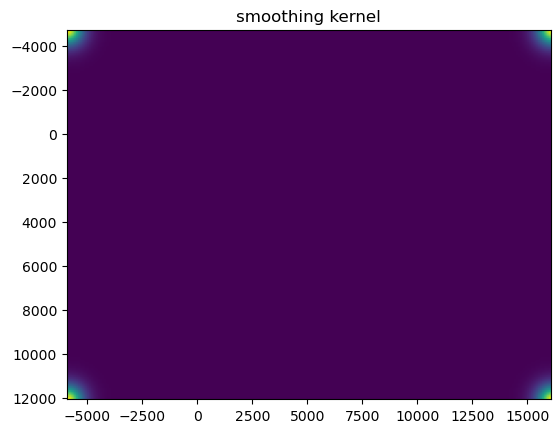

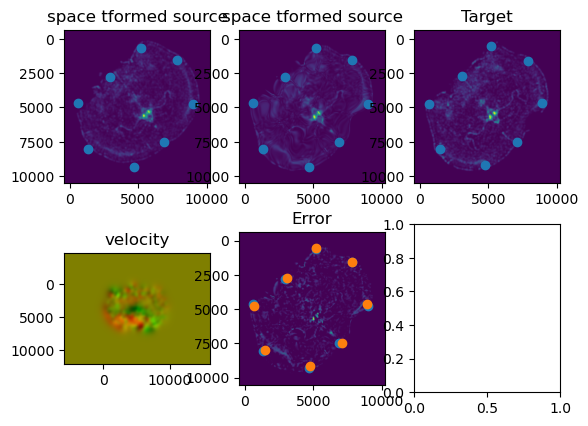

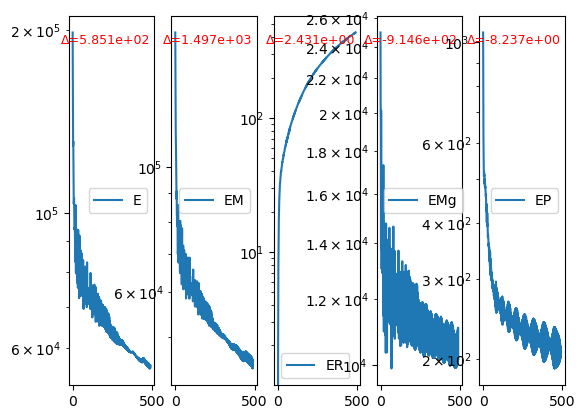

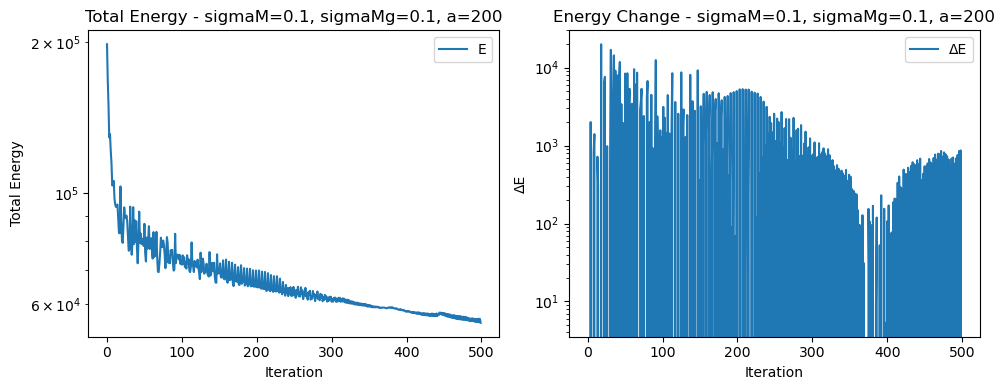

In [40]:
# sigmaM_list = [0.1, 0.5]
# sigmaMg_list = [0.1, 0.5]
#a_list = [200, 700]
a_list = [200]
sigmaM_list = [0.1]
sigmaMg_list = [0.1]

results = run_LDDMM_sweep(
    LDDMM_func=LDDMM,
    xI=[YJ, XJ], I=Xct2, 
    xJ=[YI, XI], J=Xct1,
    Ig=Xg2[[22,33,40,42,48], :, :],
    Jg=Xg1[[22,33,40,42,48], :, :],
    pointsI=pointsJ, # flipped from init by accident!! 
    pointsJ=pointsI,
    sigmaM_list=sigmaM_list,
    sigmaMg_list=sigmaMg_list,
    a_list=a_list,
    niter=500, 
    A=A
)

plot_LDDMM_results(results)

In [47]:
[np.arange(0,1,0.1) + 0.1]

[array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])]

Running LDDMM with sigmaM=0.25, sigmaMg=0.25, a=100


/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/3834269516.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(A[:2,:2],device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/3834269516.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(A[:2,-1],device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/3834269516.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.ten

Running LDDMM with sigmaM=0.25, sigmaMg=0.25, a=200
Running LDDMM with sigmaM=0.25, sigmaMg=0.25, a=500
Running LDDMM with sigmaM=0.25, sigmaMg=0.25, a=700
Running LDDMM with sigmaM=0.25, sigmaMg=0.25, a=1000


/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/1493314102.py:83: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


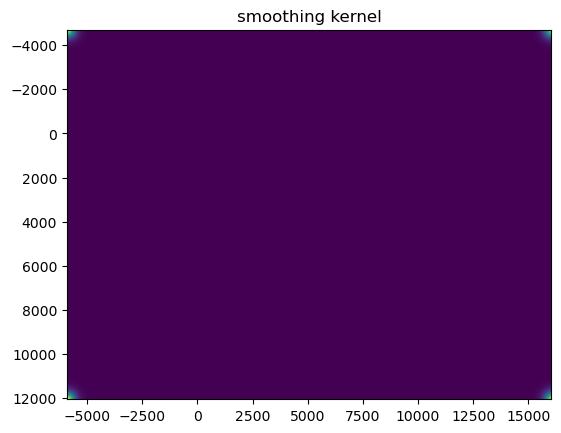

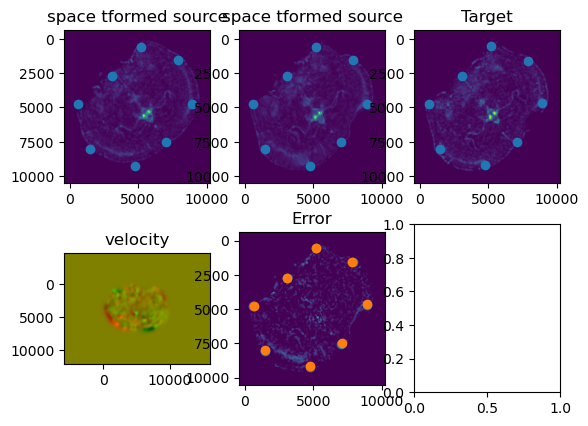

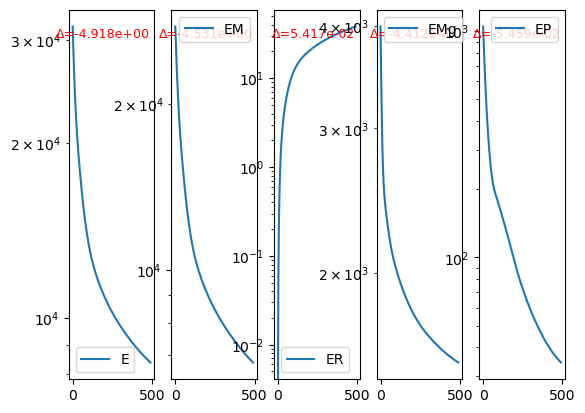

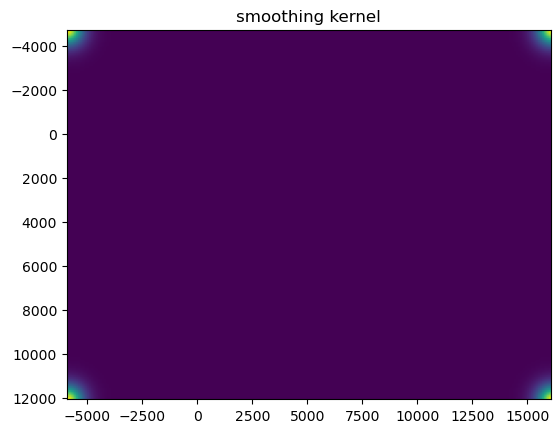

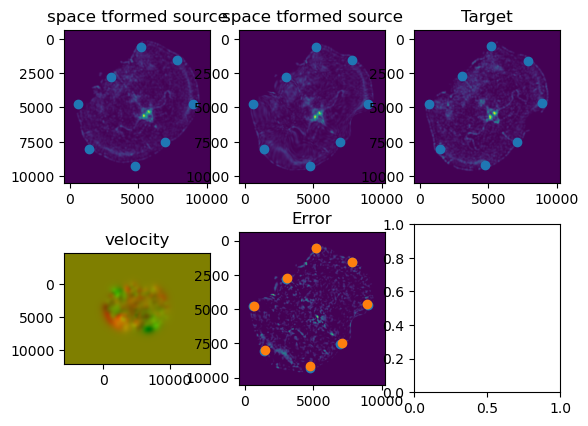

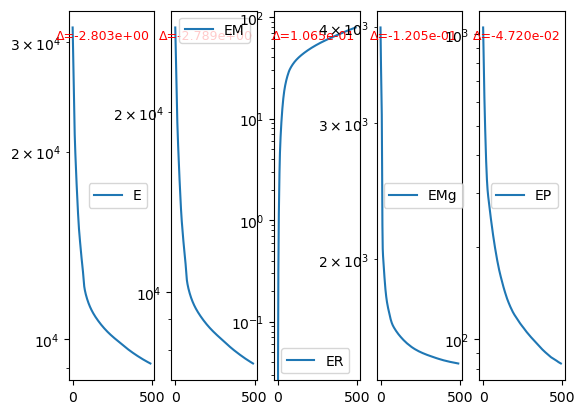

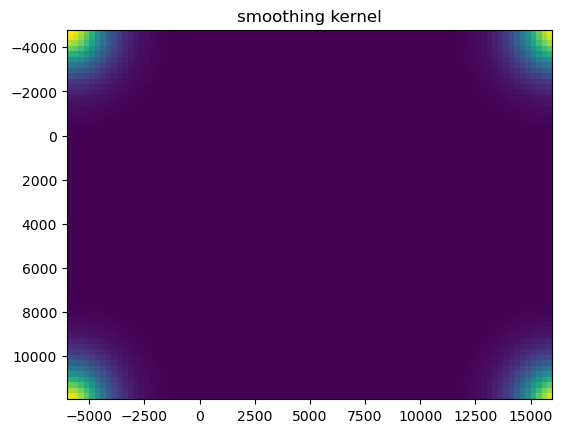

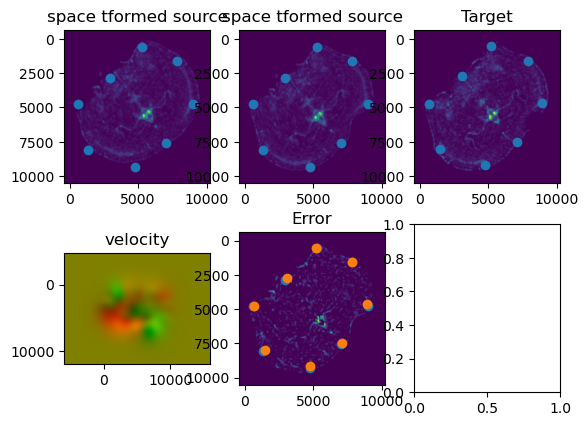

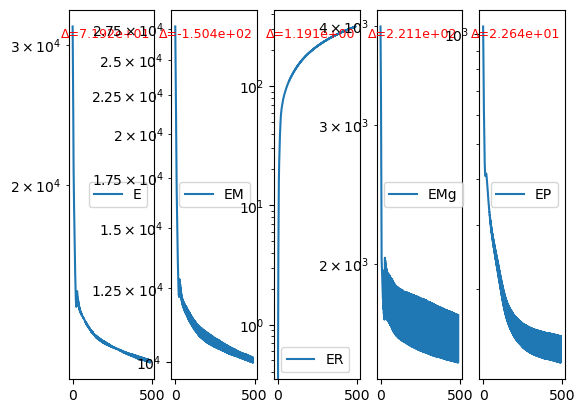

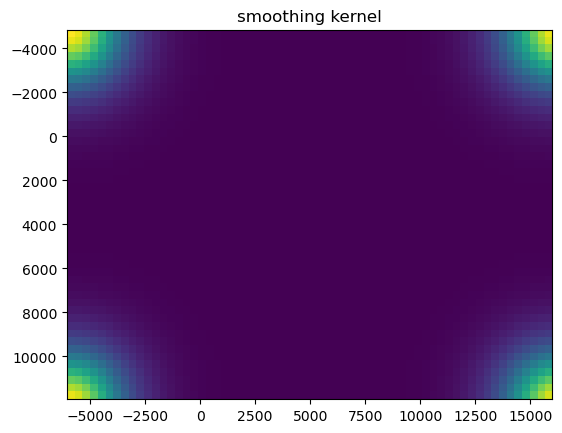

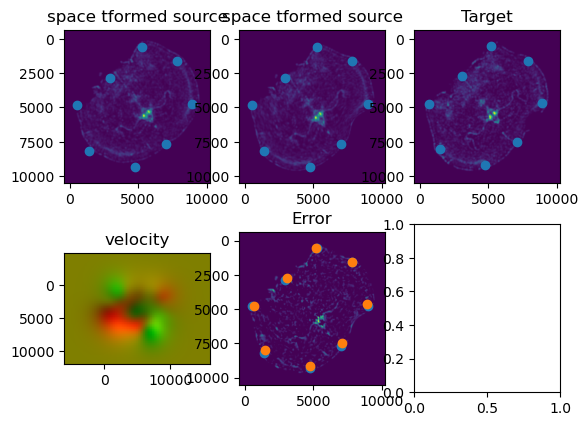

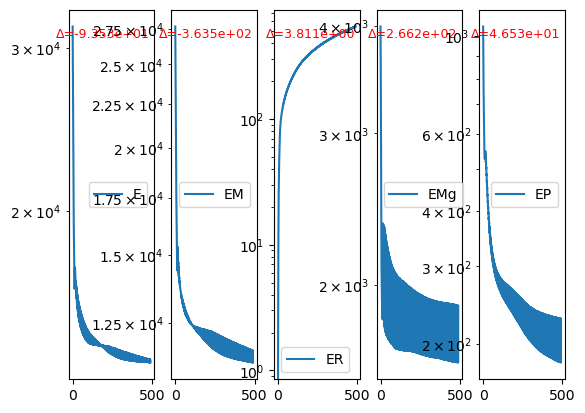

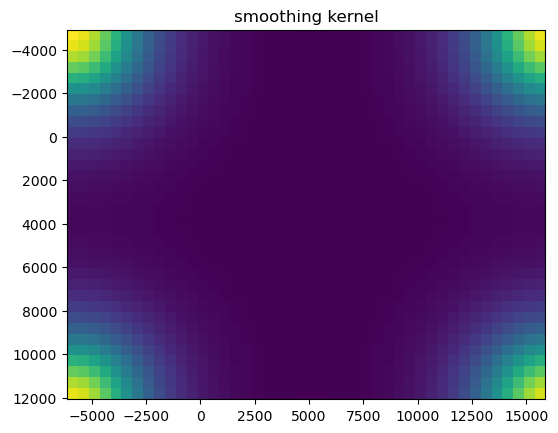

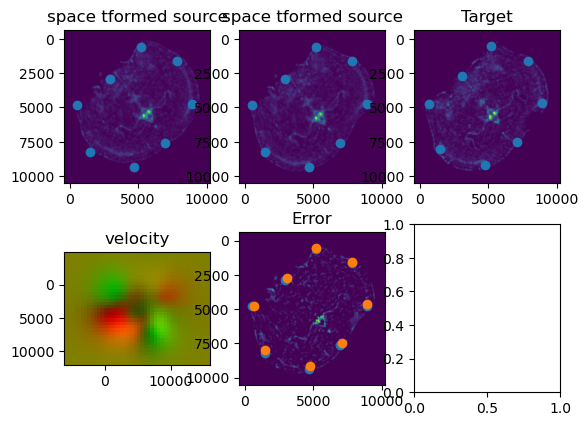

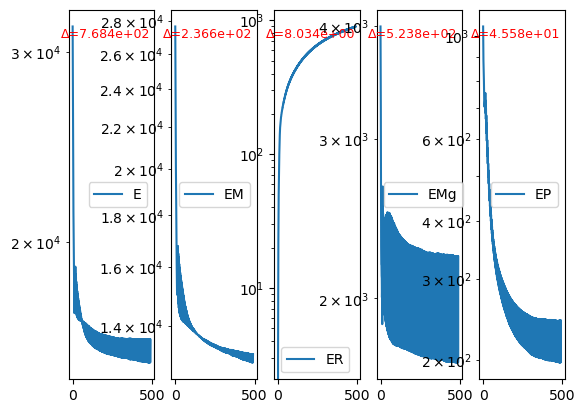

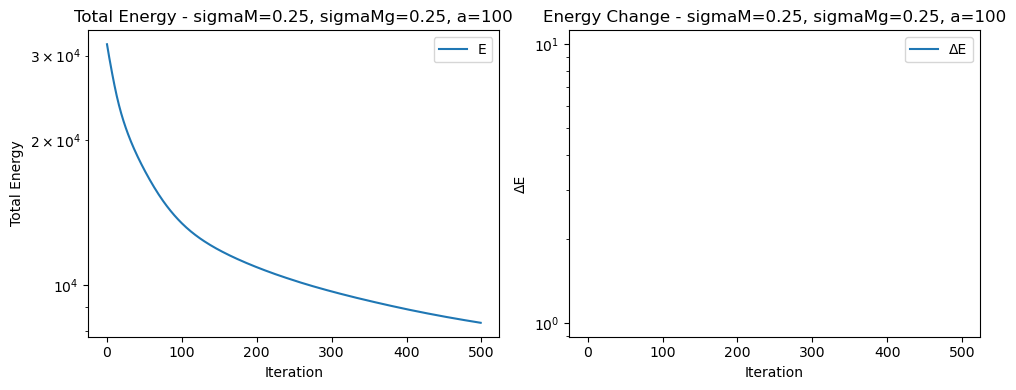

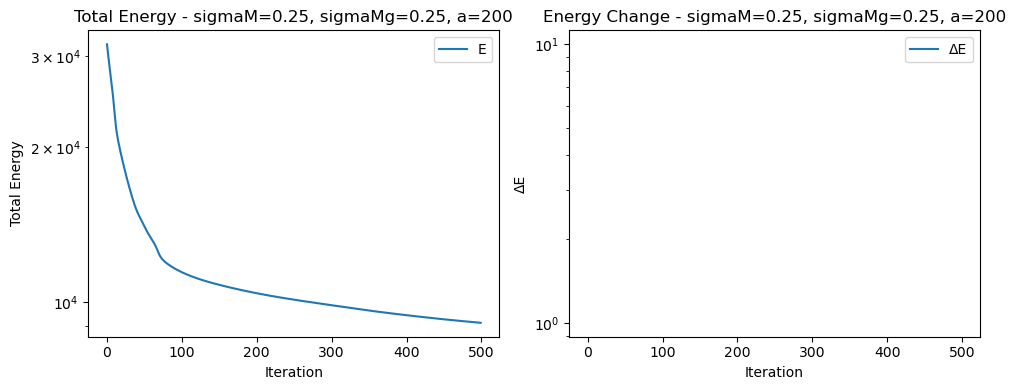

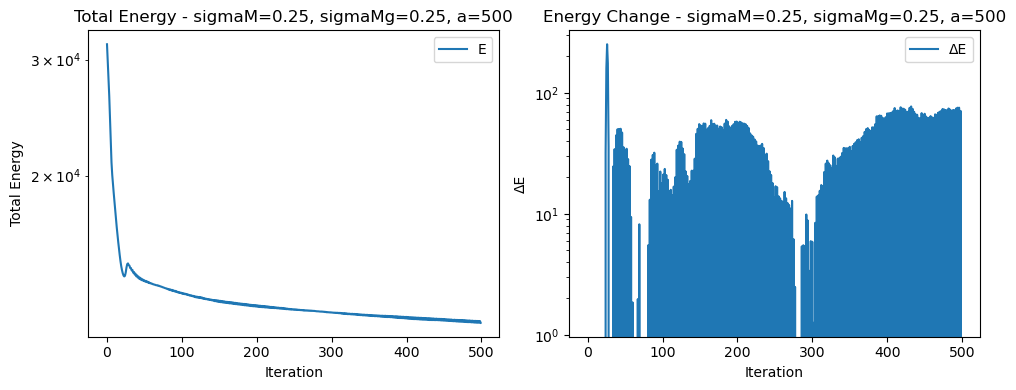

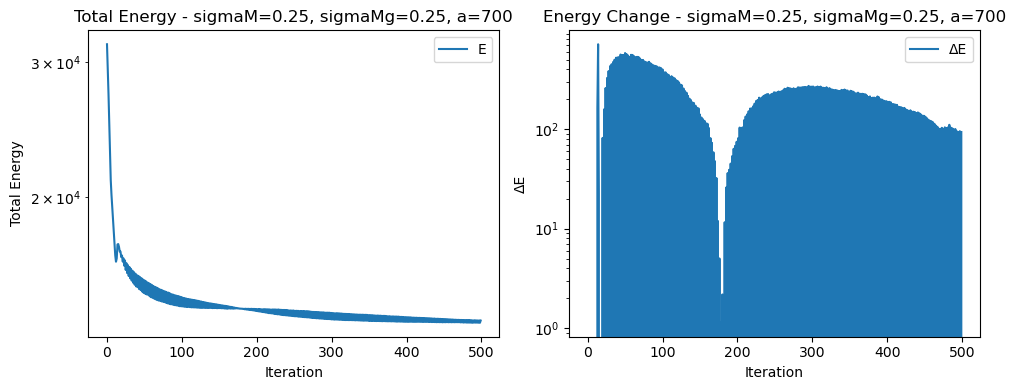

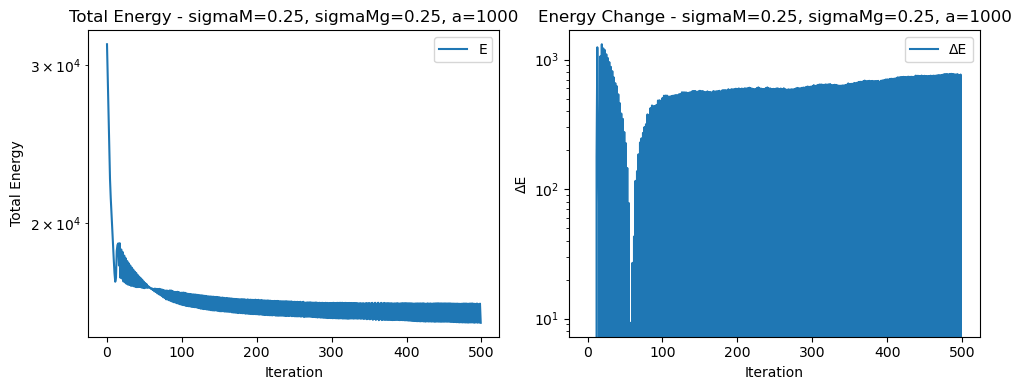

In [50]:
# sigmaM_list = [0.1, 0.5]
# sigmaMg_list = [0.1, 0.5]
#a_list = [200, 700]
a_list = [100, 200, 500, 700, 1000]
# sigmaM_list = np.arange(0.1, 1.1, 0.1)
# sigmaMg_list = np.arange(0.1, 1.1, 0.1)

results = run_LDDMM_sweep(
    LDDMM_func=LDDMM,
    xI=[YJ, XJ], I=Xct2, 
    xJ=[YI, XI], J=Xct1,
    Ig=Xg2[[22,33,40,42,48], :, :],
    Jg=Xg1[[22,33,40,42,48], :, :],
    pointsI=pointsJ, # flipped from init by accident!! 
    pointsJ=pointsI,
    sigmaM_list=[0.25],
    sigmaMg_list=[0.25],
    a_list=a_list,
    niter=500, 
    A=A
)

plot_LDDMM_results(results)

In [55]:
import matplotlib.pyplot as plt

def plot_energy_vs_a(results):
    """
    Plot total energy and deltaE across different 'a' values.

    Parameters:
    -----------
    results : list of dicts
        Each dict corresponds to one LDDMM run and should contain:
            'a' : hyperparameter
            'total_energy' : list/array of total energy values per iteration
            'deltaE' : list/array of change in energy per iteration
    """
    # Sort results by increasing a
    results_sorted = sorted(results, key=lambda x: x['a'])
    
    # --- Plot Total Energy ---
    plt.figure(figsize=(10,5))
    for res in results_sorted:
        plt.plot(res['total_energy'], marker='o', 
                 markersize=0.1, label=f"a={res['a']}")
    plt.xlabel('Iteration')
    plt.ylabel('Total Energy')
    plt.title('Total Energy vs Iteration for different a')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # --- Plot Change in Energy ---
    plt.figure(figsize=(10,5))
    for res in results_sorted:
        plt.plot(res['deltaE'], marker='x', 
                 markersize=2, label=f"a={res['a']}")
    plt.xlabel('Iteration')
    plt.ylabel('Δ Energy')
    plt.title('Change in Energy vs Iteration for different a')
    plt.yscale('log')  # helps visualize small energy changes
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

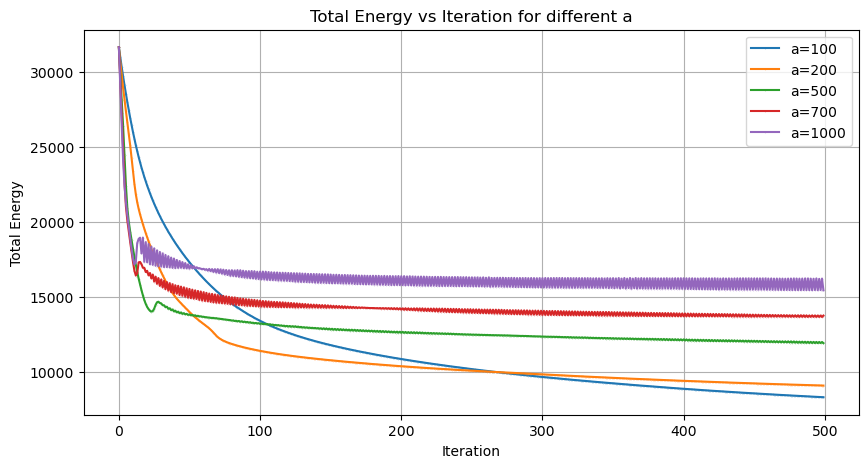

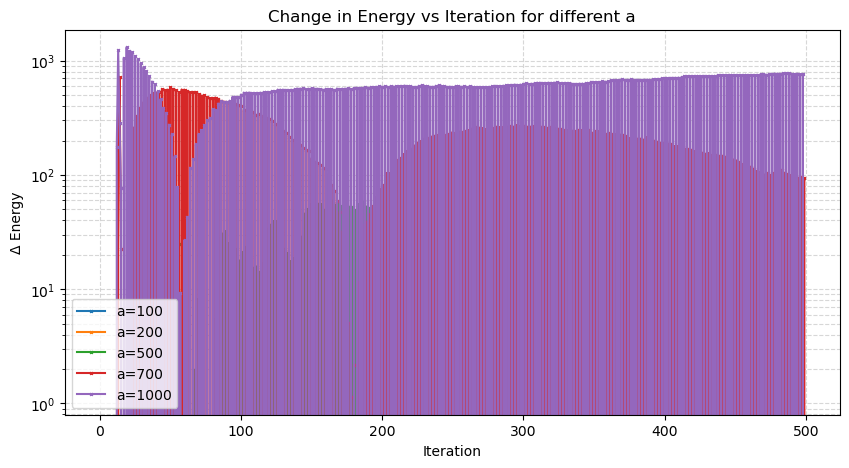

In [56]:
plot_energy_vs_a(results)

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_LDDMM_hyperparam_analysis(results, fixed_sigmaM, fixed_sigmaMg):
    """
    Plot total energy, delta energy, and final energy heatmaps to select optimal parameters.
    
    Parameters
    ----------
    results : list of dicts
        Each dict must contain:
        - 'a', 'sigmaM', 'sigmaMg'
        - 'total_energy' : list of total energy per iteration
        - 'deltaE' : list of change in energy per iteration
    fixed_sigmaM : float
        sigmaM value to fix for line plots
    fixed_sigmaMg : float
        sigmaMg value to fix for line plots
    """
    # Convert results to DataFrame for easier manipulation
    df = pd.DataFrame({
        'a': [r['a'] for r in results],
        'sigmaM': [r['sigmaM'] for r in results],
        'sigmaMg': [r['sigmaMg'] for r in results],
        'total_energy': [r['total_energy'] for r in results],
        'deltaE': [r['deltaE'] for r in results],
        'final_energy': [r['total_energy'][-1] for r in results]
    })
    
    # --- 1️⃣ Total Energy vs Iteration for all a ---
    plt.figure(figsize=(10,5))
    subset = df[(df['sigmaM']==fixed_sigmaM) & (df['sigmaMg']==fixed_sigmaMg)]
    for _, row in subset.iterrows():
        plt.plot(row['total_energy'], marker='o', markersize=4, label=f"a={row['a']}")
    plt.xlabel("Iteration")
    plt.ylabel("Total Energy")
    plt.title(f"Total Energy vs Iteration (sigmaM={fixed_sigmaM}, sigmaMg={fixed_sigmaMg})")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # --- 2️⃣ Delta Energy vs Iteration for all a ---
    plt.figure(figsize=(10,5))
    for _, row in subset.iterrows():
        plt.plot(row['deltaE'], marker='x', markersize=4, label=f"a={row['a']}")
    plt.xlabel("Iteration")
    plt.ylabel("Δ Energy")
    plt.title(f"Δ Energy vs Iteration (sigmaM={fixed_sigmaM}, sigmaMg={fixed_sigmaMg})")
    plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()
    
    # --- 3️⃣ Heatmaps of final energy across sigmaM and sigmaMg for each a ---
    for a_val in sorted(df['a'].unique()):
        subset_a = df[df['a'] == a_val].pivot(index='sigmaM', columns='sigmaMg', values='final_energy')
        plt.figure(figsize=(8,6))
        sns.heatmap(subset_a, annot=True, fmt=".2f", cmap="viridis")
        plt.title(f"Final Energy Heatmap for a={a_val}")
        plt.xlabel("sigmaMg")
        plt.ylabel("sigmaM")
        plt.show()
    
    # --- 4️⃣ Best parameter selection ---
    best_row = df.loc[df['final_energy'].idxmin()]
    print("Best parameters found:")
    print(f"a={best_row['a']}, sigmaM={best_row['sigmaM']}, sigmaMg={best_row['sigmaMg']}")
    print(f"Final energy: {best_row['final_energy']}")

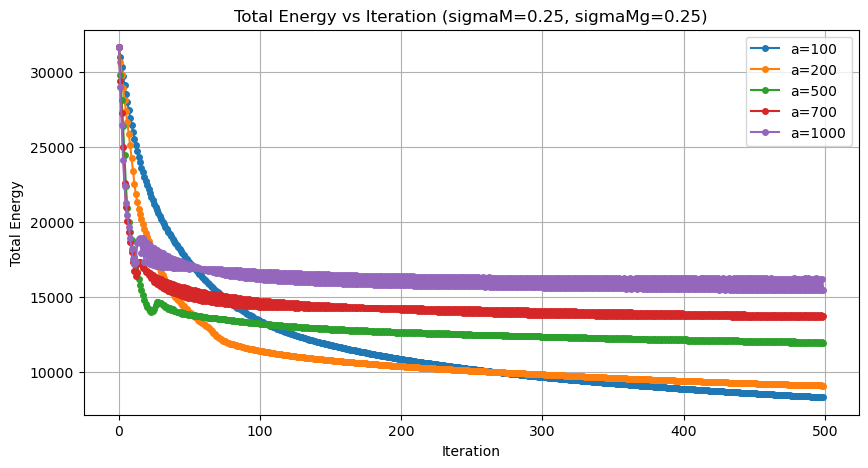

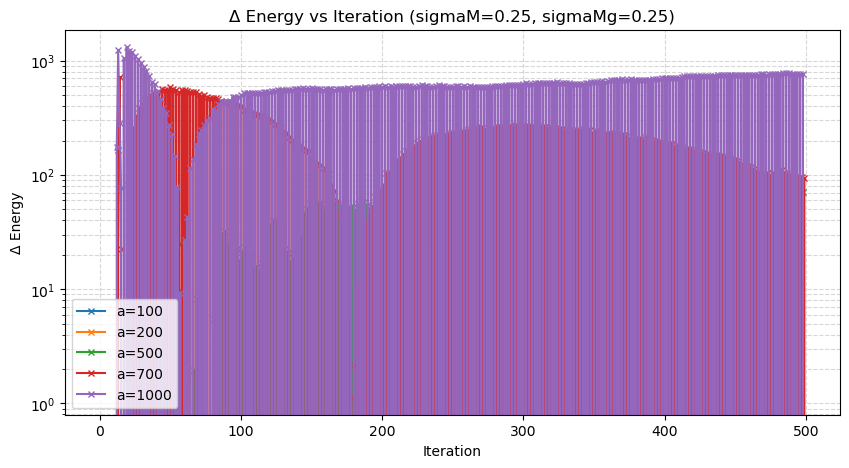

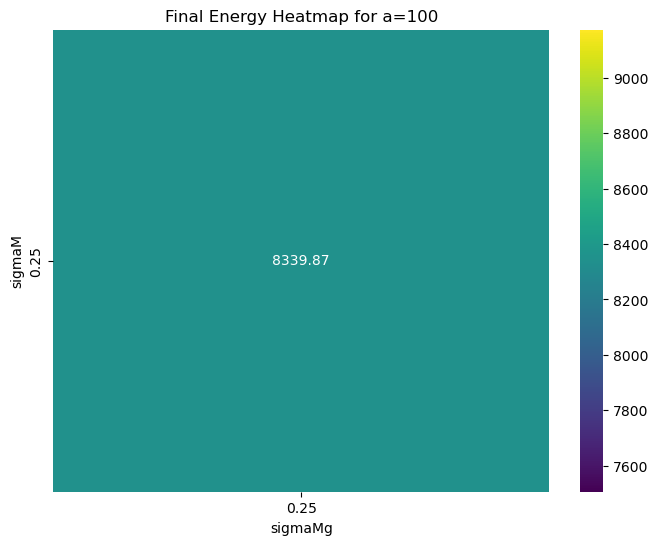

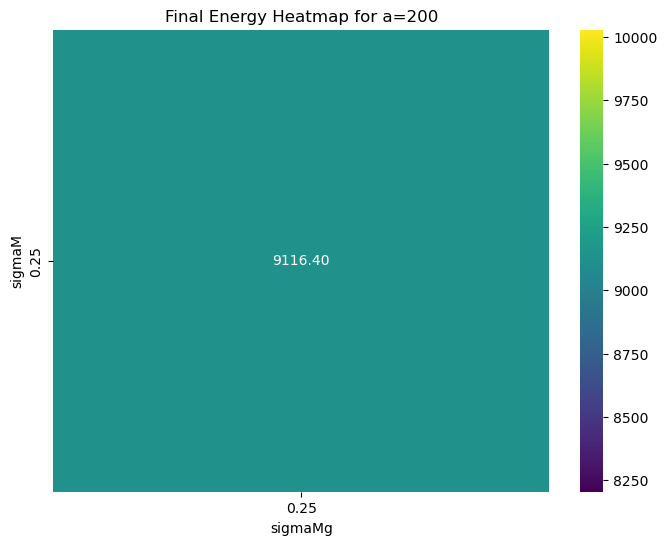

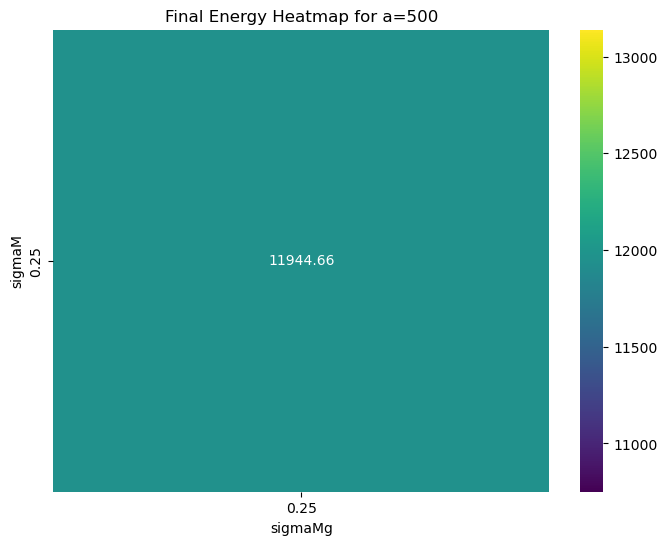

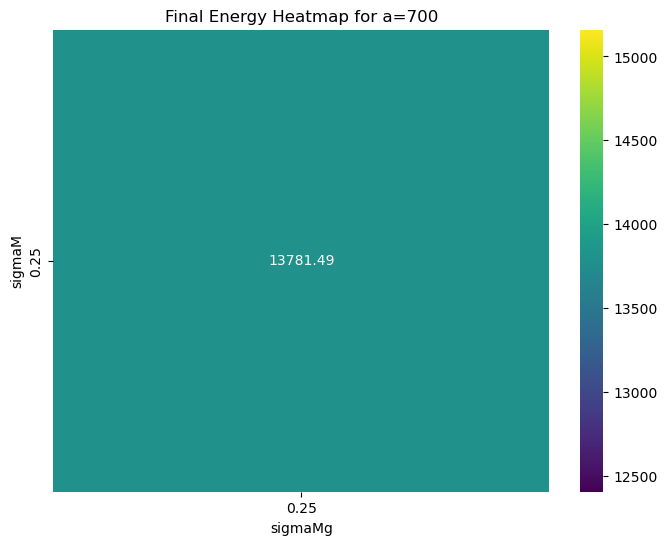

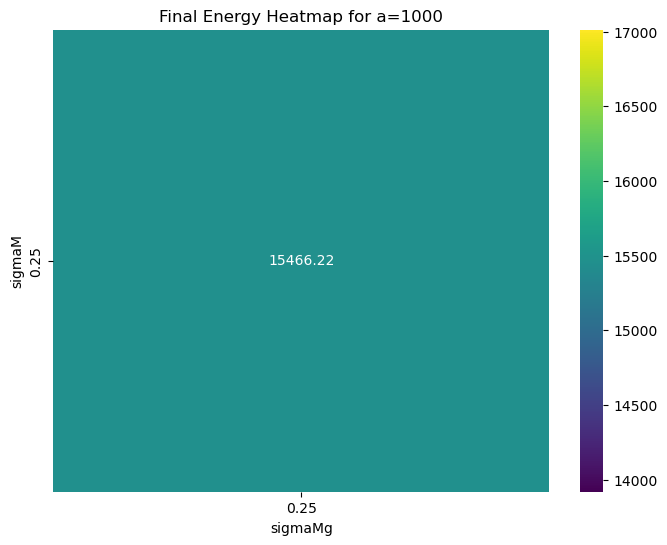

Best parameters found:
a=100, sigmaM=0.25, sigmaMg=0.25
Final energy: 8339.874019350558


In [60]:
fixed_sigmaM = 0.25
fixed_sigmaMg = 0.25

plot_LDDMM_hyperparam_analysis(results, fixed_sigmaM, fixed_sigmaMg)

In [ ]:
sigmaM_list = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0]
sigmaMg_list = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0]
a_list = [50, 100, 150, 200, 250, 300]
# sigmaM_list = np.arange(0.1, 1.1, 0.1)
# sigmaMg_list = np.arange(0.1, 1.1, 0.1)

res2 = run_LDDMM_sweep(
    LDDMM_func=LDDMM,
    xI=[YJ, XJ], I=Xct2, 
    xJ=[YI, XI], J=Xct1,
    Ig=Xg2[[22,33,40,42,48], :, :],
    Jg=Xg1[[22,33,40,42,48], :, :],
    pointsI=pointsJ, # flipped from init by accident!! 
    pointsJ=pointsI,
    sigmaM_list=sigmaM_list,
    sigmaMg_list=sigmaMg_list,
    a_list=a_list,
    niter=500, 
    A=A
)

Running LDDMM with sigmaM=0.05, sigmaMg=0.05, a=50


/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/3834269516.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(A[:2,:2],device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/3834269516.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(A[:2,-1],device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/3834269516.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.ten

Running LDDMM with sigmaM=0.05, sigmaMg=0.05, a=100
Running LDDMM with sigmaM=0.05, sigmaMg=0.05, a=150
Running LDDMM with sigmaM=0.05, sigmaMg=0.05, a=200
Running LDDMM with sigmaM=0.05, sigmaMg=0.05, a=250
Running LDDMM with sigmaM=0.05, sigmaMg=0.05, a=300
Running LDDMM with sigmaM=0.05, sigmaMg=0.05, a=400


/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/3834269516.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figE,axE = plt.subplots(1,5)


KeyboardInterrupt: 

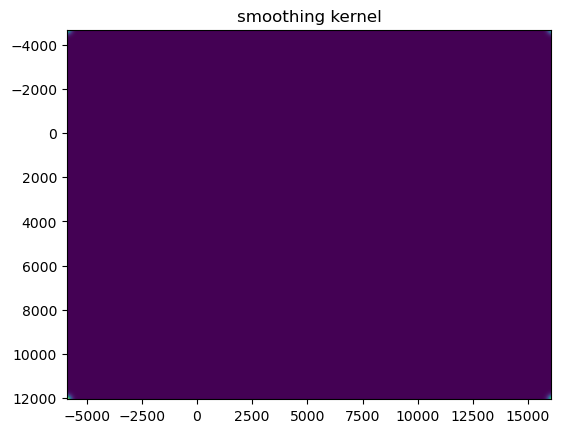

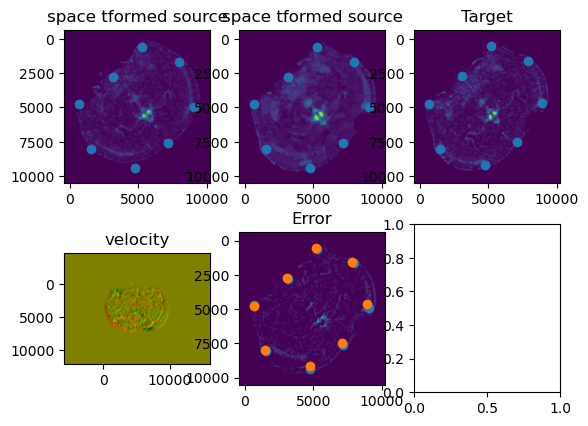

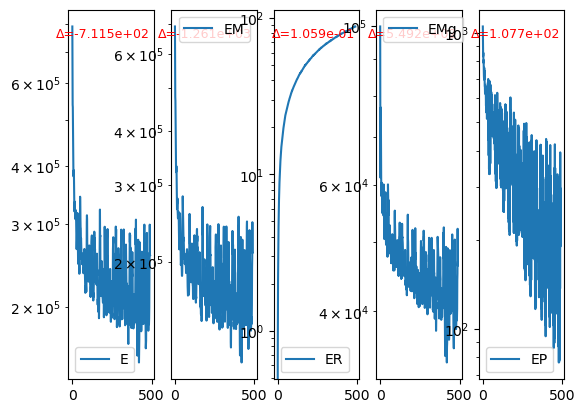

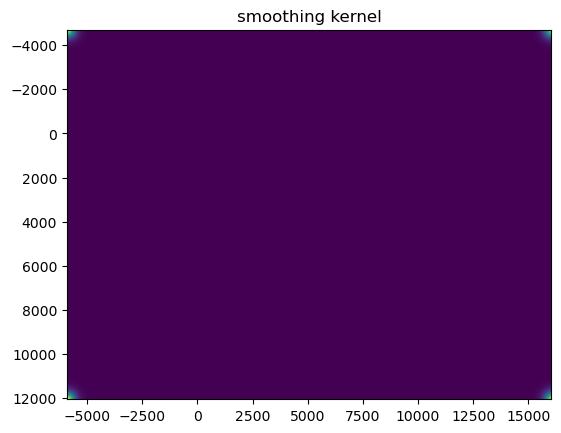

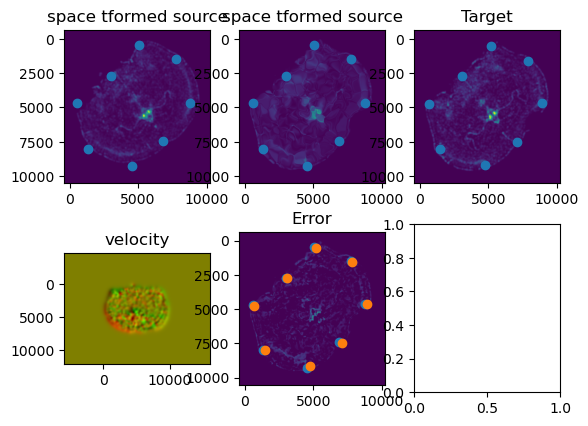

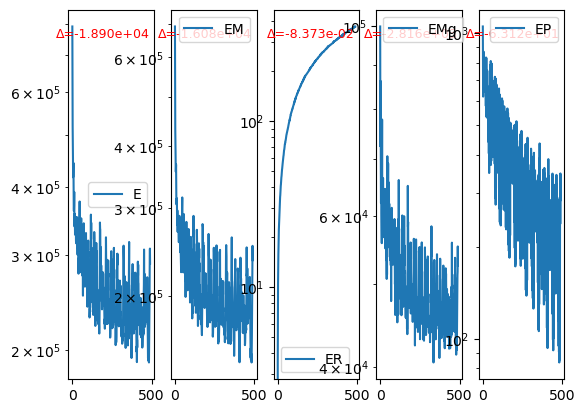

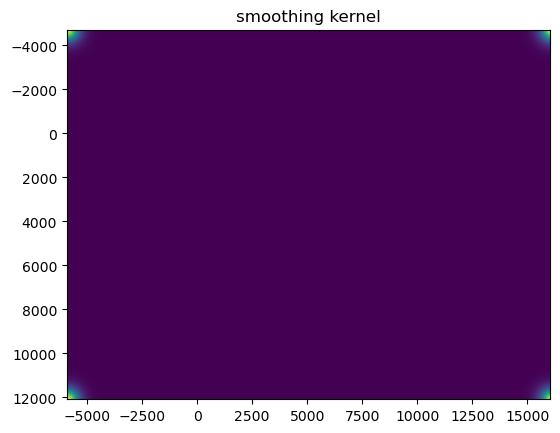

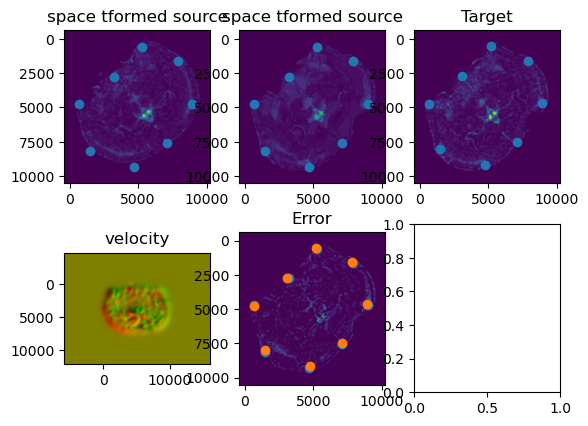

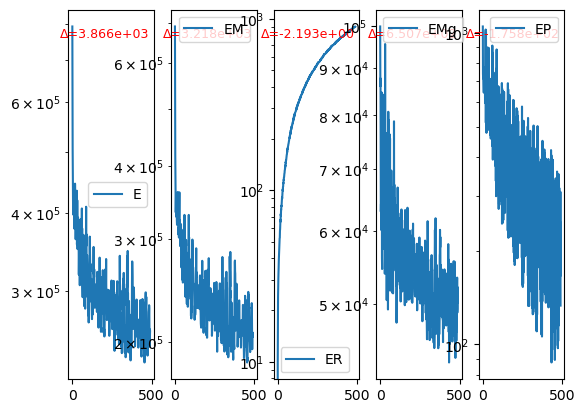

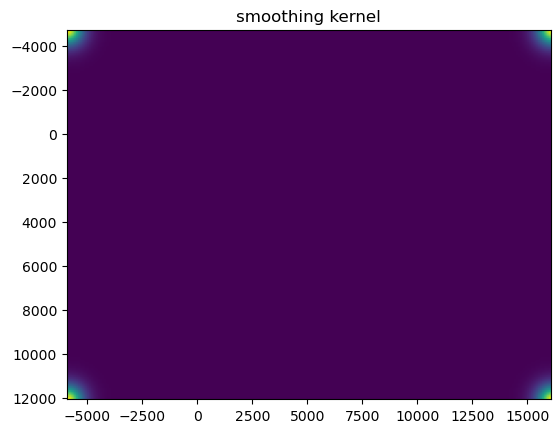

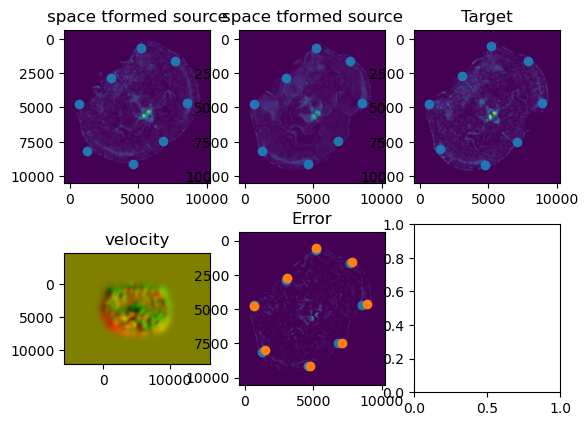

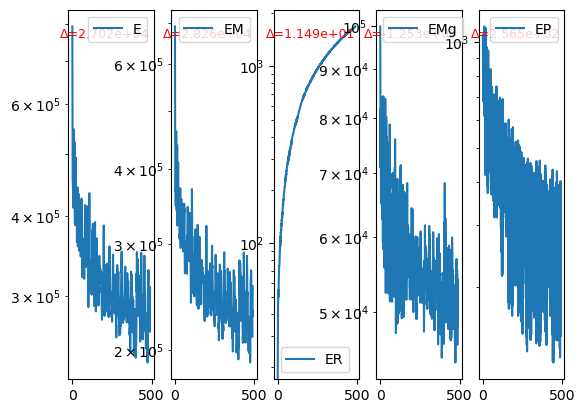

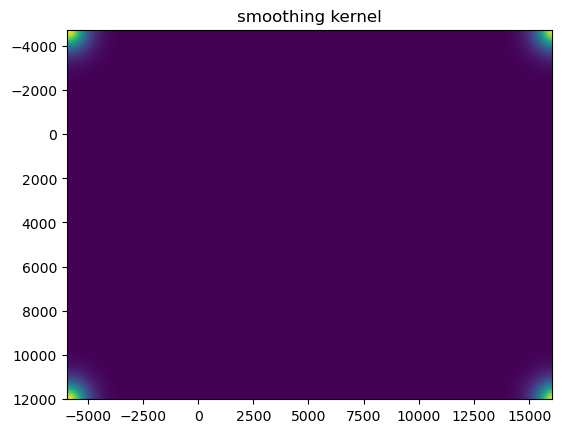

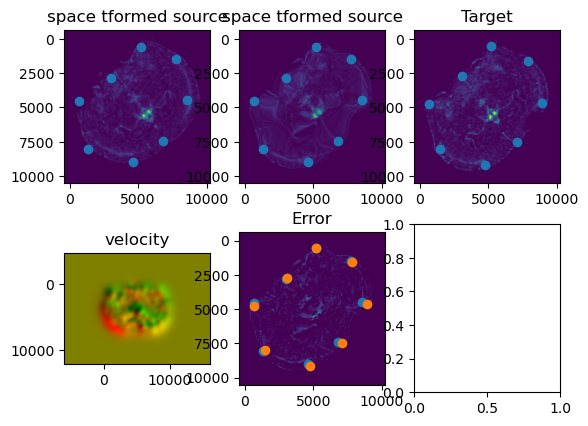

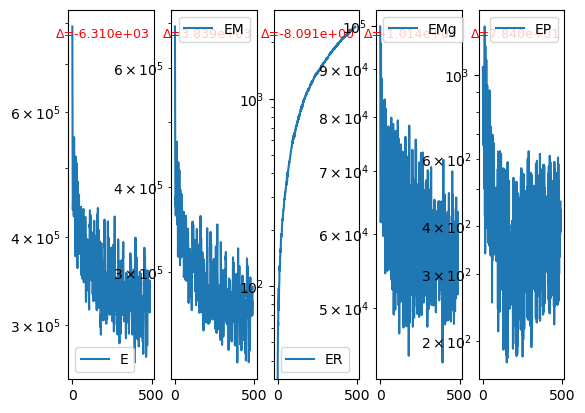

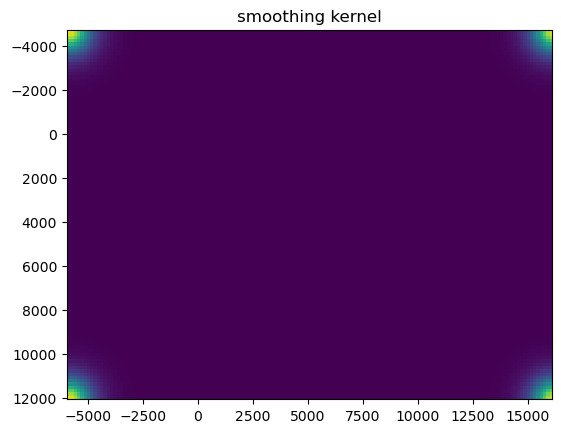

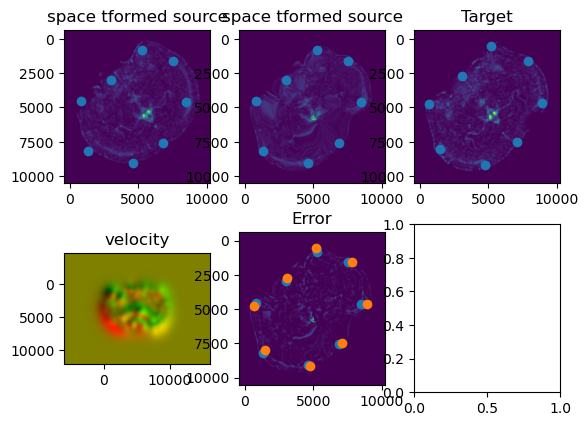

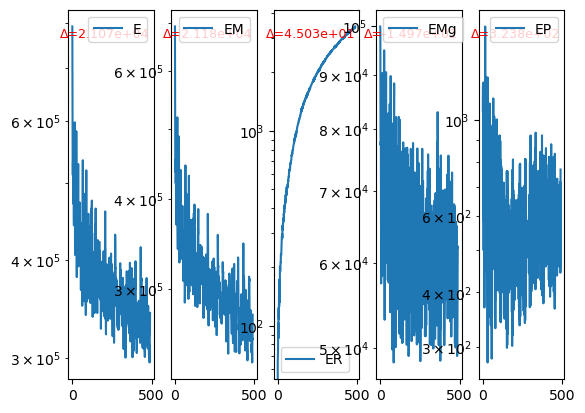

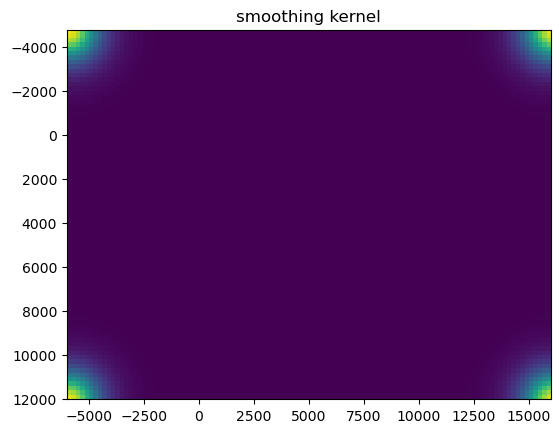

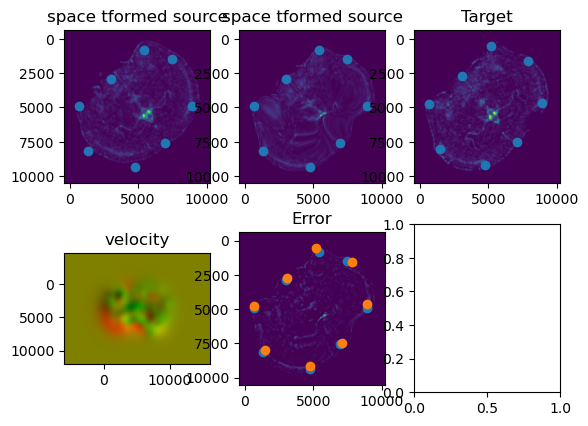

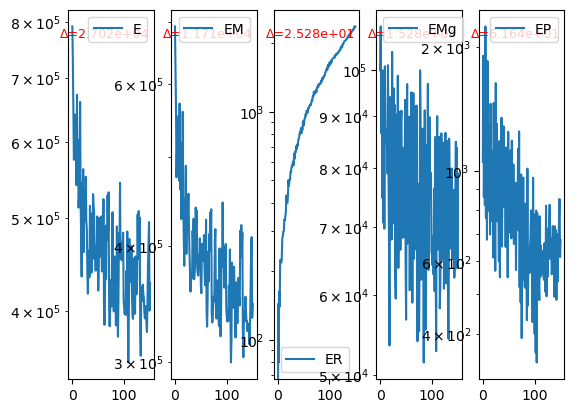

In [62]:
sigmaM_list = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0]
sigmaMg_list = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0]
a_list = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 1000]
# sigmaM_list = np.arange(0.1, 1.1, 0.1)
# sigmaMg_list = np.arange(0.1, 1.1, 0.1)

res2 = run_LDDMM_sweep(
    LDDMM_func=LDDMM,
    xI=[YJ, XJ], I=Xct2, 
    xJ=[YI, XI], J=Xct1,
    Ig=Xg2[[22,33,40,42,48], :, :],
    Jg=Xg1[[22,33,40,42,48], :, :],
    pointsI=pointsJ, # flipped from init by accident!! 
    pointsJ=pointsI,
    sigmaM_list=sigmaM_list,
    sigmaMg_list=sigmaMg_list,
    a_list=a_list,
    niter=500, 
    A=A
)

Running LDDMM with sigmaM=0.25, sigmaMg=0.25, a=50


/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/3834269516.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(A[:2,:2],device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/3834269516.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(A[:2,-1],device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/3834269516.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.ten

Running LDDMM with sigmaM=0.25, sigmaMg=0.25, a=75


/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/1493314102.py:83: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


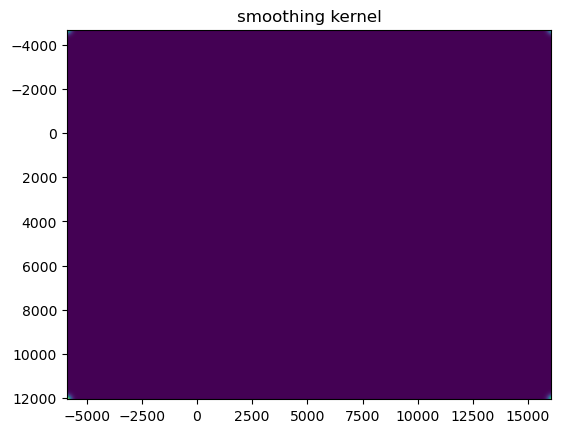

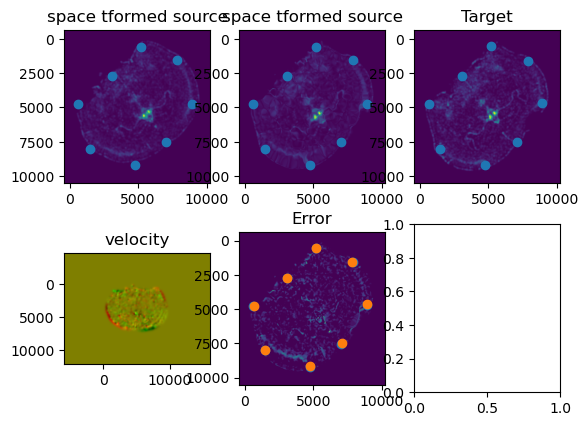

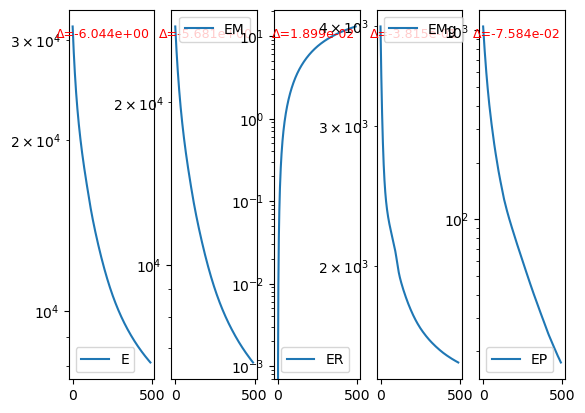

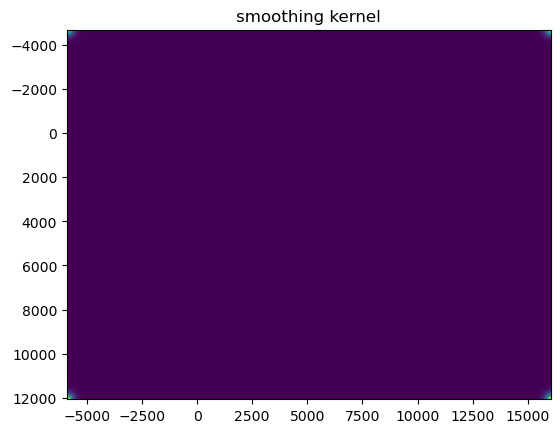

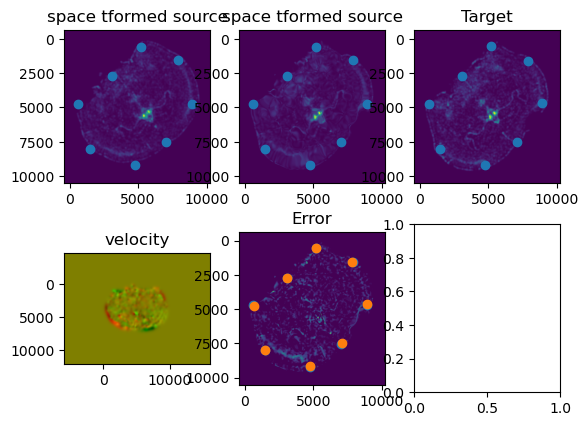

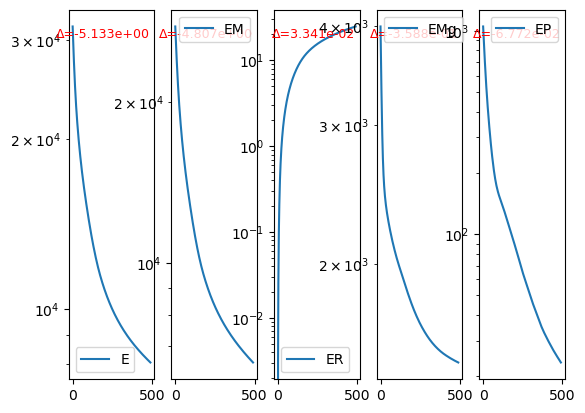

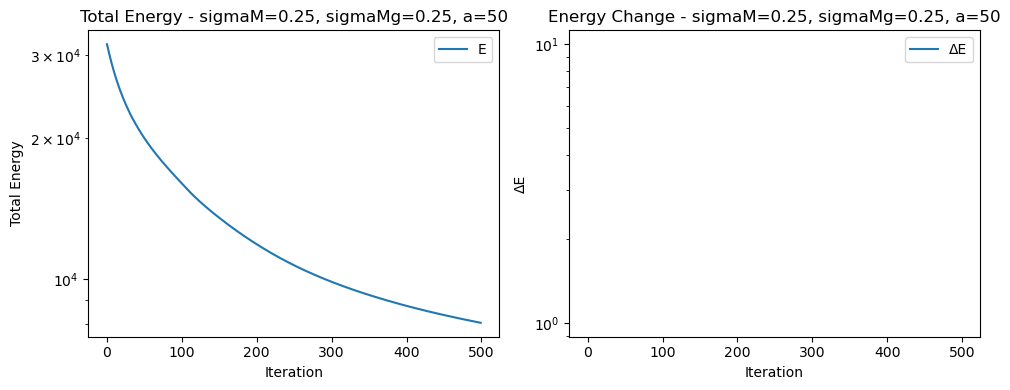

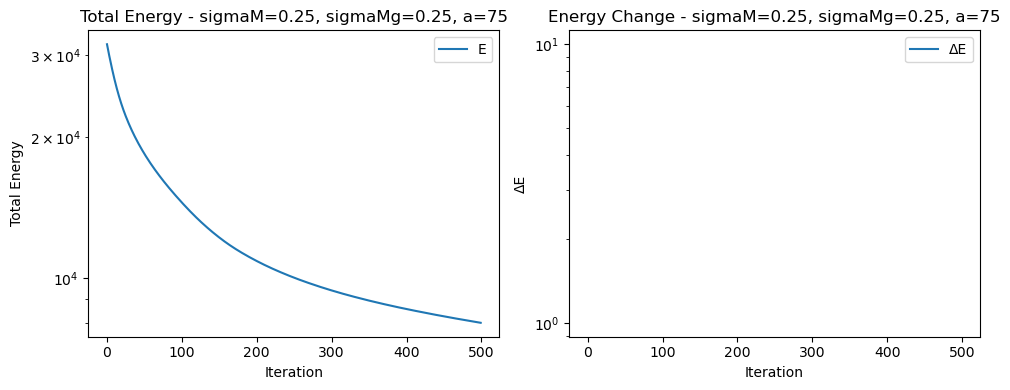

In [70]:
# sigmaM_list = [0.05, 0.1, 0.15, 0.2]
# sigmaMg_list = [0.2, 0.4, 0.9]
a_list = [50, 75]
# sigmaM_list = np.arange(0.1, 1.1, 0.1)
# sigmaMg_list = np.arange(0.1, 1.1, 0.1)

results = run_LDDMM_sweep(
    LDDMM_func=LDDMM,
    xI=[YJ, XJ], I=Xct2, 
    xJ=[YI, XI], J=Xct1,
    Ig=Xg2[[22,33,40,42,48], :, :],
    Jg=Xg1[[22,33,40,42,48], :, :],
    pointsI=pointsJ, # flipped from init by accident!! 
    pointsJ=pointsI,
    sigmaM_list=[0.25],
    sigmaMg_list=[0.25],
    a_list=a_list,
    niter=500, 
    A=A
)

plot_LDDMM_results(results)


Summary table:
   sigmaM  sigmaMg   a      E_final      E_change
0    0.25     0.25  50  8059.049354  23604.851571
1    0.25     0.25  75  8005.151043  23658.749883


/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/1493314102.py:123: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(E_matrix, origin='lower', extent=[min(sigmaMg_vals), max(sigmaMg_vals),
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/1493314102.py:123: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(E_matrix, origin='lower', extent=[min(sigmaMg_vals), max(sigmaMg_vals),


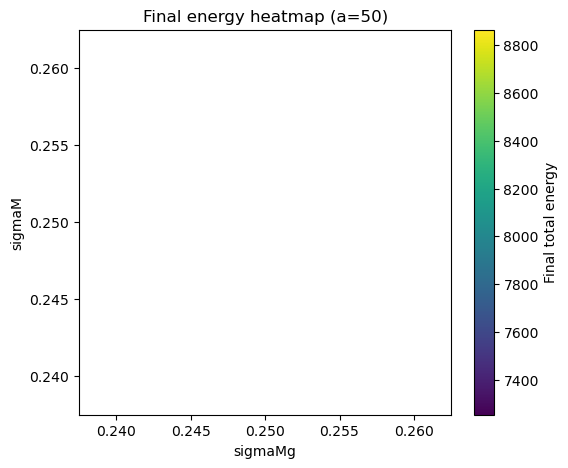

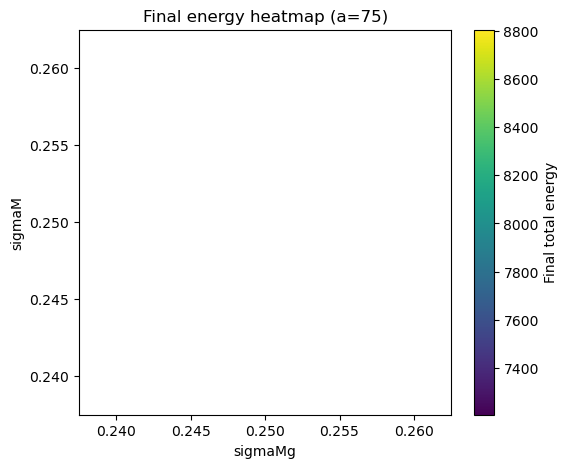

sigmaM  sigmaMg   a      E_final      E_change
0    0.25     0.25  50  8059.049354  23604.851571
1    0.25     0.25  75  8005.151043  23658.749883

In [72]:
summarize_results(results)

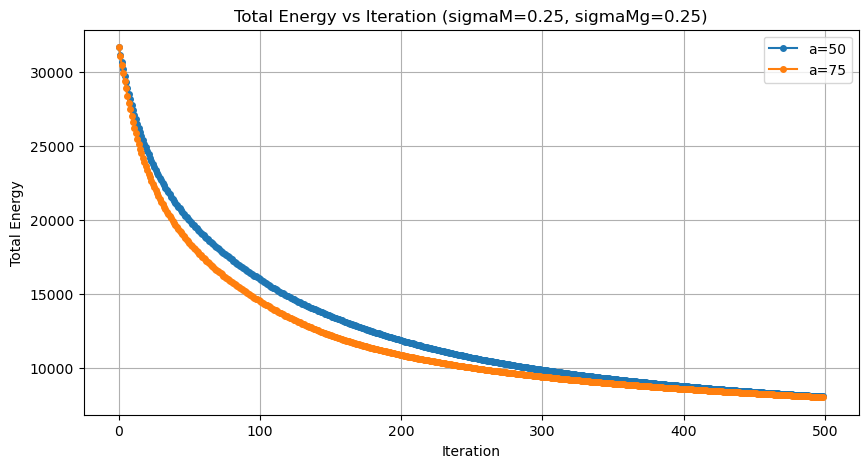

/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/1807400440.py:50: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


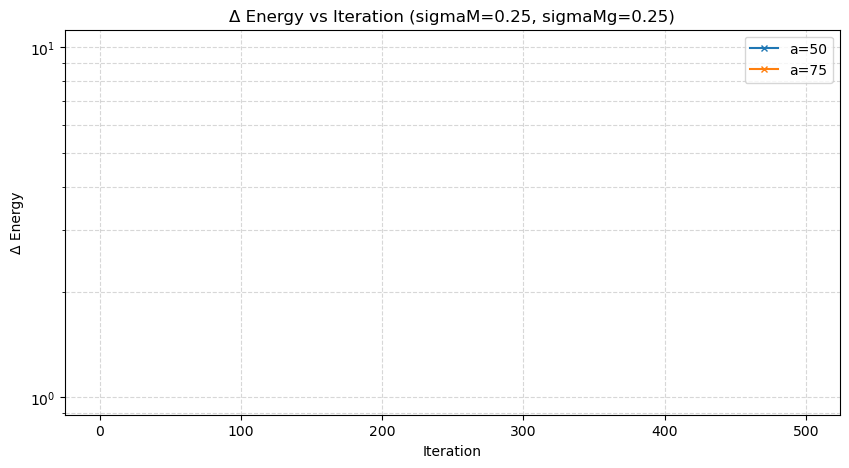

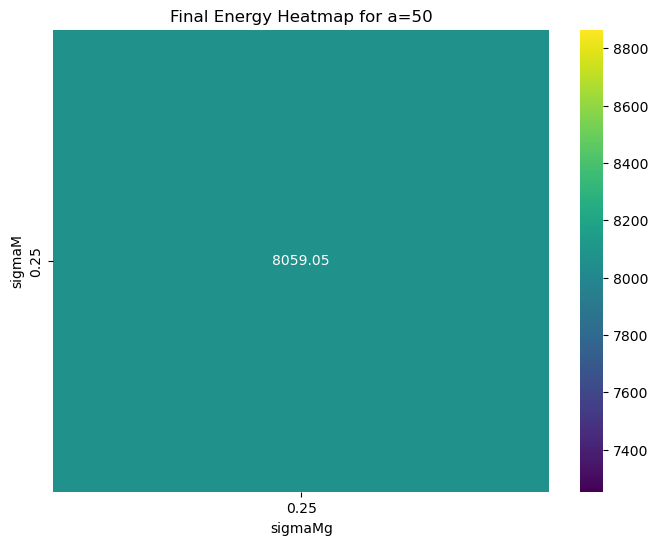

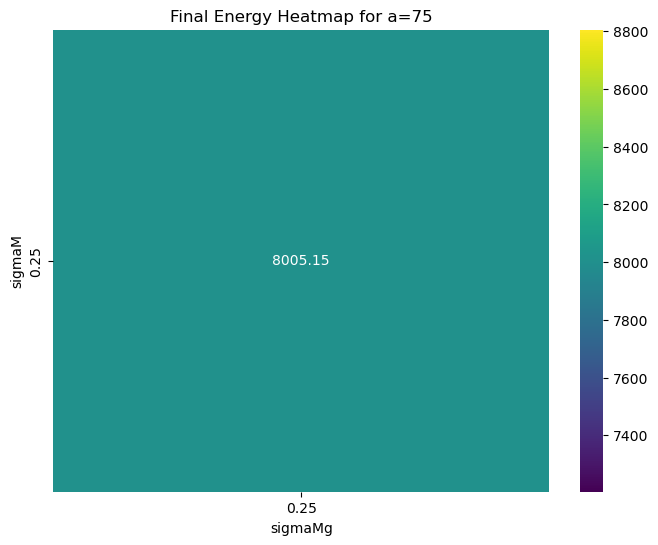

Best parameters found:
a=75, sigmaM=0.25, sigmaMg=0.25
Final energy: 8005.151042869287


In [73]:
fixed_sigmaM = 0.25
fixed_sigmaMg = 0.25

plot_LDDMM_hyperparam_analysis(results, fixed_sigmaM, fixed_sigmaMg)

Running LDDMM with sigmaM=0.25, sigmaMg=0.25, a=75


/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/3834269516.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(A[:2,:2],device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/3834269516.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(A[:2,-1],device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/3834269516.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.ten

Running LDDMM with sigmaM=0.25, sigmaMg=0.25, a=80
Running LDDMM with sigmaM=0.25, sigmaMg=0.25, a=85
Running LDDMM with sigmaM=0.25, sigmaMg=0.25, a=90
Running LDDMM with sigmaM=0.25, sigmaMg=0.25, a=100


/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/1493314102.py:83: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


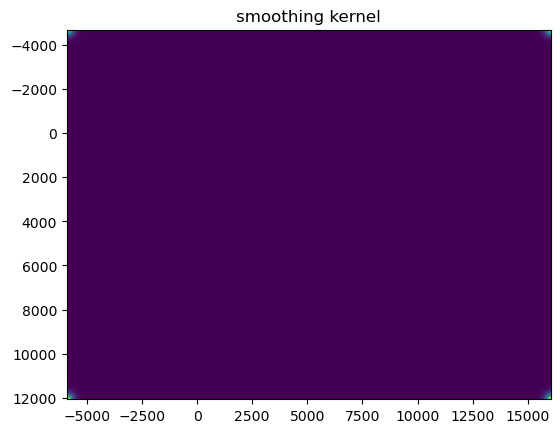

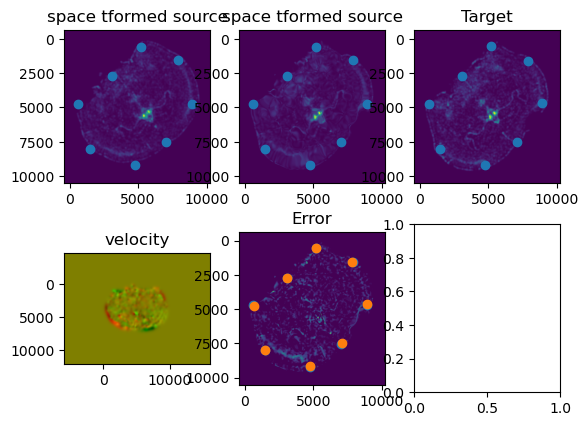

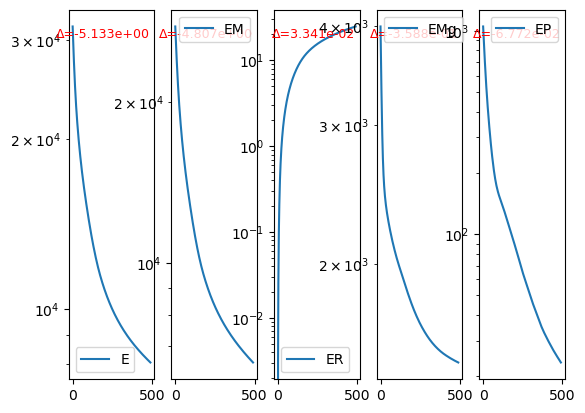

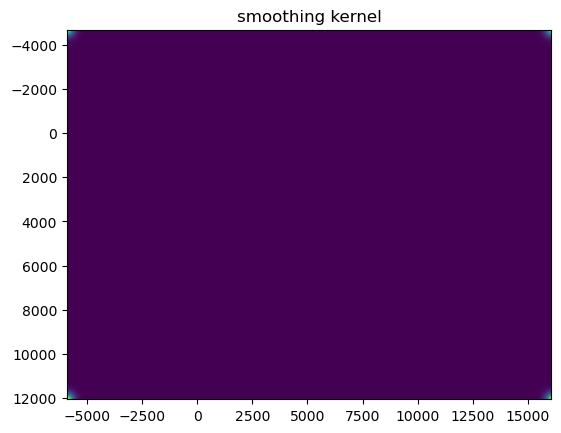

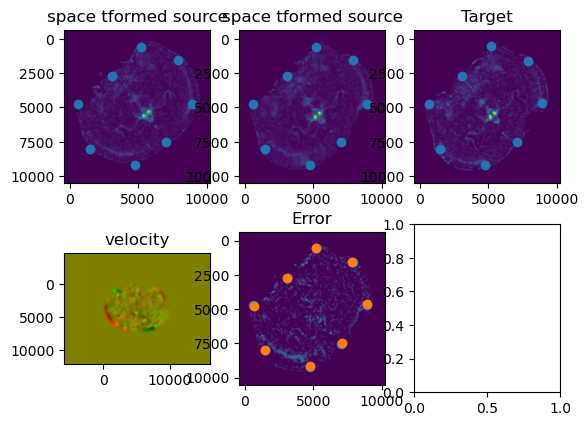

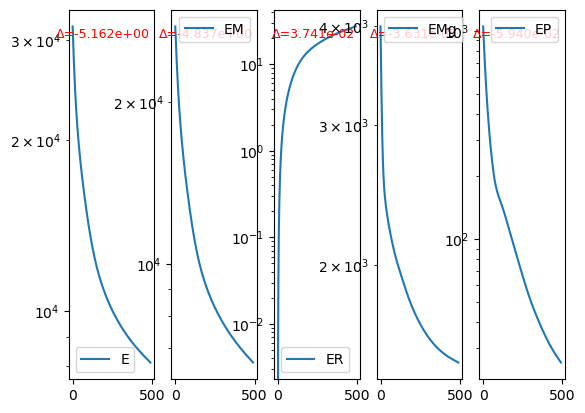

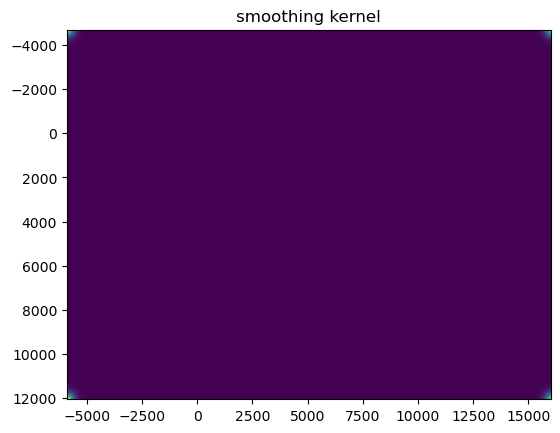

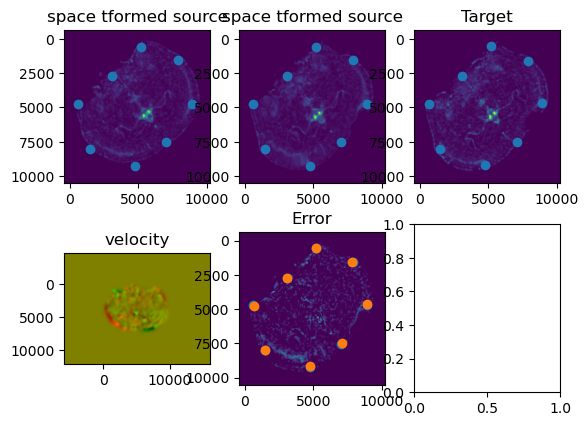

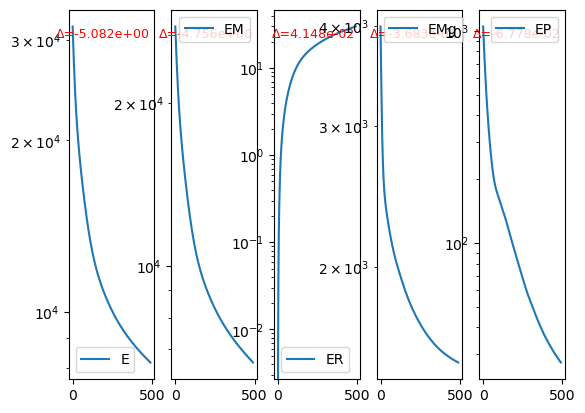

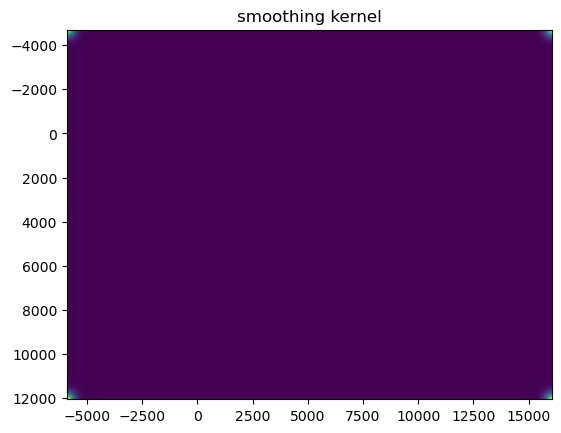

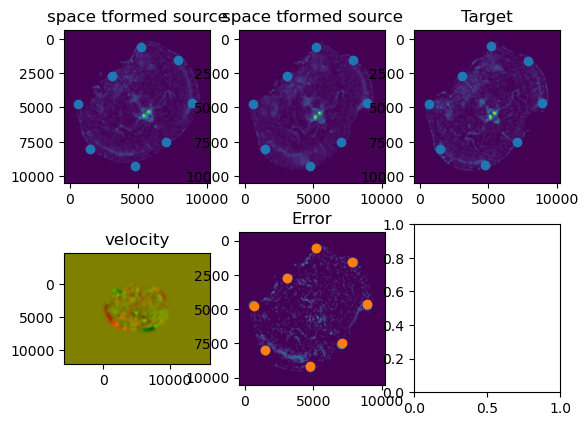

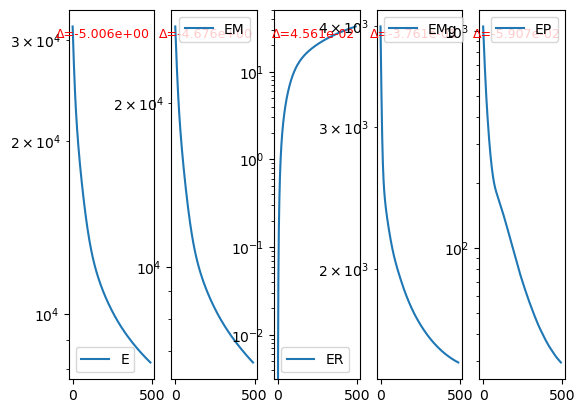

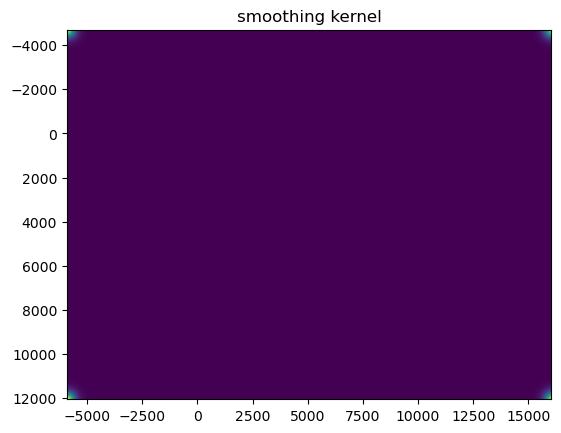

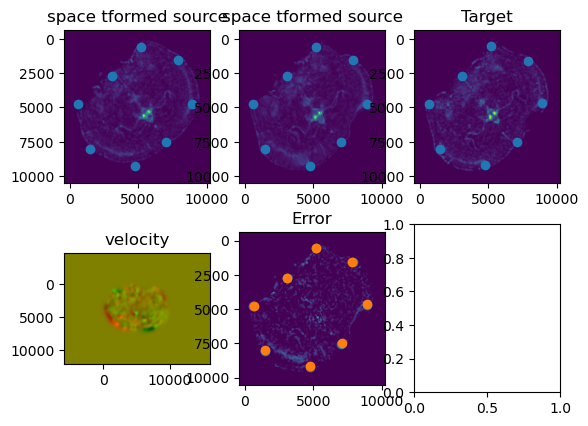

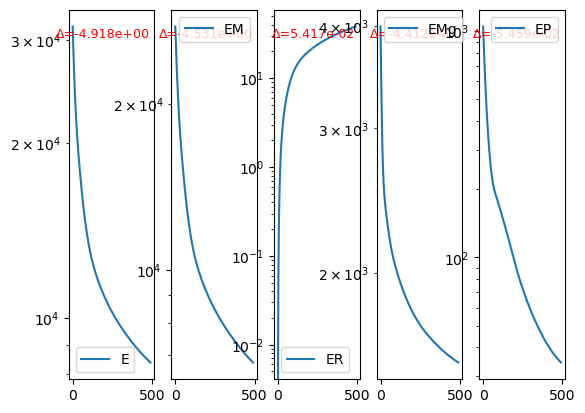

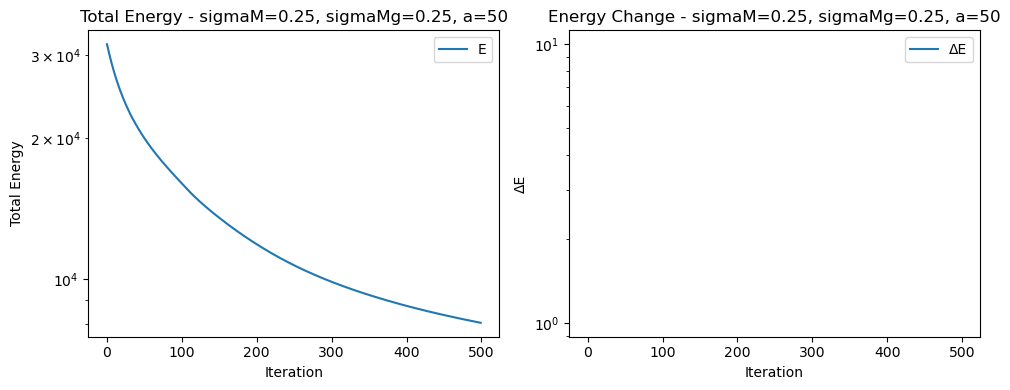

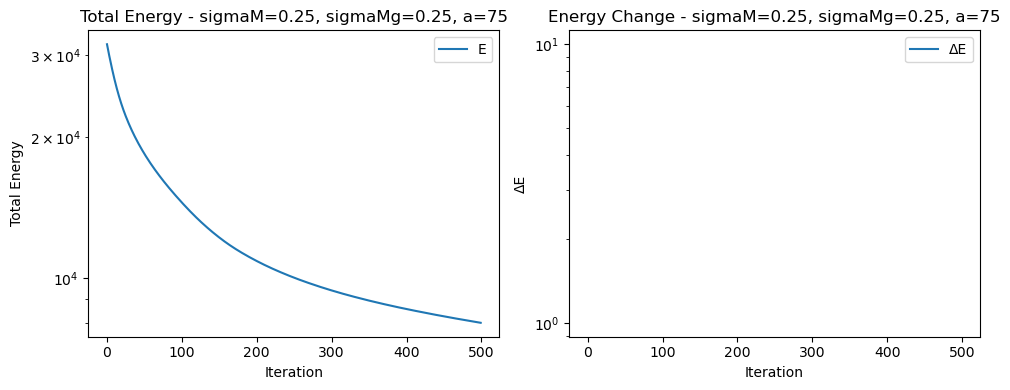

In [74]:
# sigmaM_list = [0.05, 0.1, 0.15, 0.2]
# sigmaMg_list = [0.2, 0.4, 0.9]
a_list = [75, 80, 85, 90, 100]
# sigmaM_list = np.arange(0.1, 1.1, 0.1)
# sigmaMg_list = np.arange(0.1, 1.1, 0.1)

res_lower_a = run_LDDMM_sweep(
    LDDMM_func=LDDMM,
    xI=[YJ, XJ], I=Xct2, 
    xJ=[YI, XI], J=Xct1,
    Ig=Xg2[[22,33,40,42,48], :, :],
    Jg=Xg1[[22,33,40,42,48], :, :],
    pointsI=pointsJ, # flipped from init by accident!! 
    pointsJ=pointsI,
    sigmaM_list=[0.25],
    sigmaMg_list=[0.25],
    a_list=a_list,
    niter=500, 
    A=A
)

plot_LDDMM_results(results)


Summary table:
   sigmaM  sigmaMg    a      E_final      E_change
0    0.25     0.25   75  8005.151043  23658.749883
1    0.25     0.25   80  8058.439410  23605.461515
2    0.25     0.25   85  8121.113673  23542.787253
3    0.25     0.25   90  8178.826770  23485.074156
4    0.25     0.25  100  8339.874019  23324.026906


/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/1493314102.py:123: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(E_matrix, origin='lower', extent=[min(sigmaMg_vals), max(sigmaMg_vals),
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_56230/1493314102.py:123: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(E_matrix, origin='lower', extent=[min(sigmaMg_vals), max(sigmaMg_vals),


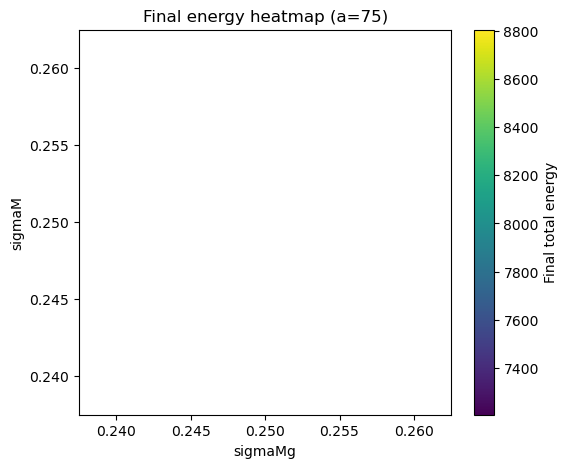

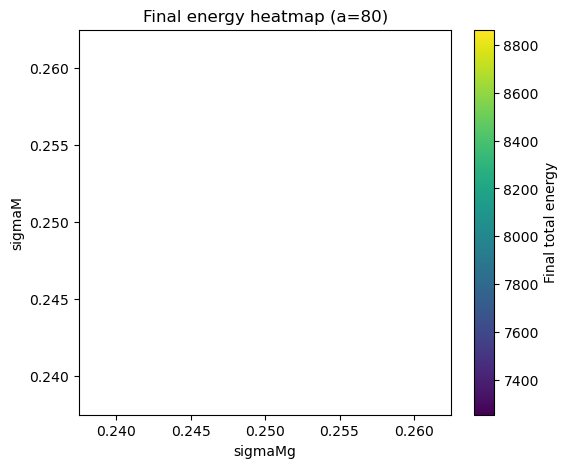

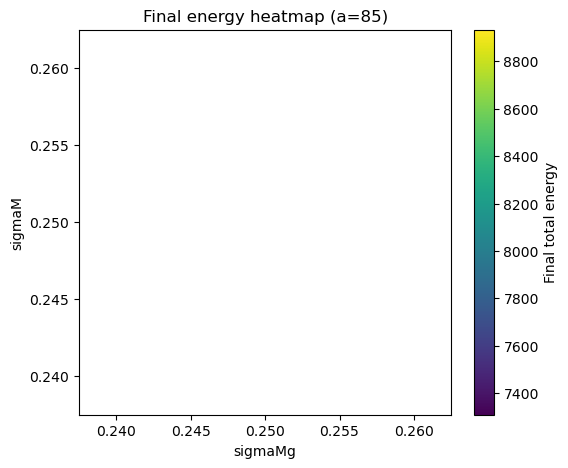

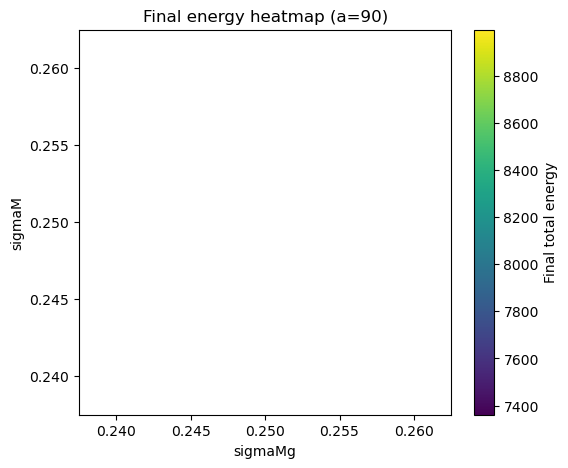

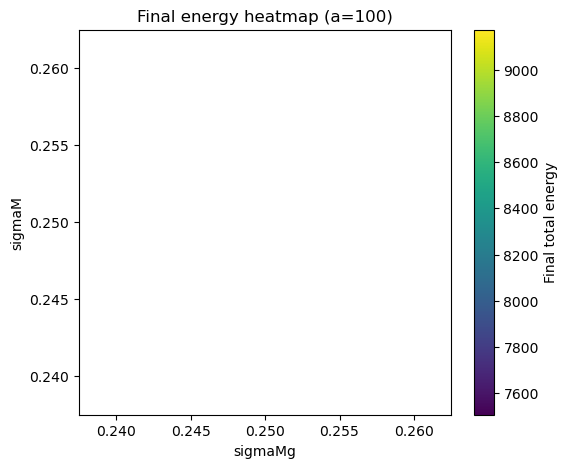

sigmaM  sigmaMg    a      E_final      E_change
0    0.25     0.25   75  8005.151043  23658.749883
1    0.25     0.25   80  8058.439410  23605.461515
2    0.25     0.25   85  8121.113673  23542.787253
3    0.25     0.25   90  8178.826770  23485.074156
4    0.25     0.25  100  8339.874019  23324.026906

In [76]:
summarize_results(res_lower_a)

In [ ]:
sigmaM_list = [0.1, 0.5, 1.0]
sigmaMg_list = [0.1, 0.5, 1.0]
a_list = [200, 500, 700]

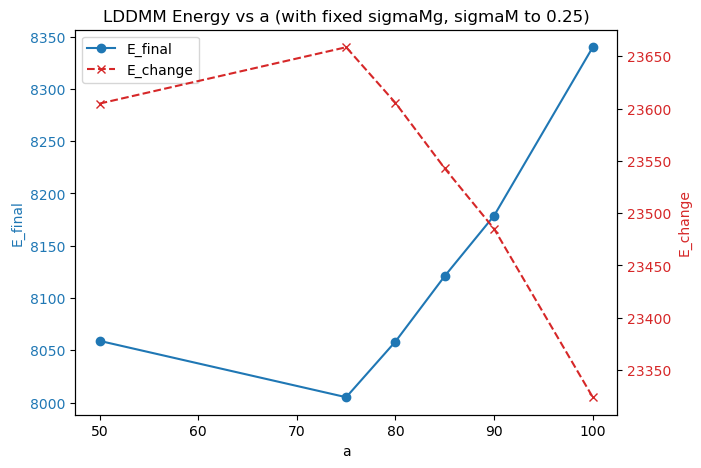

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Your data
a_values = np.array([50, 75, 80, 85, 90, 100])
E_final = np.array([8059.049354, 8005.151043, 8058.439410, 8121.113673, 8178.826770, 8339.874019])
E_change = np.array([23604.851571, 23658.749883, 23605.461515, 23542.787253, 23485.074156, 23324.026906])

# Plotting
fig, ax1 = plt.subplots(figsize=(7,5))

color1 = 'tab:blue'
ax1.set_xlabel('a')
ax1.set_ylabel('E_final', color=color1)
ax1.plot(a_values, E_final, marker='o', color=color1, label='E_final')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_title('LDDMM Energy vs a (with fixed sigmaMg, sigmaM to 0.25)')

# Create a second y-axis for E_change
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('E_change', color=color2)
ax2.plot(a_values, E_change, marker='x', linestyle='--', color=color2, label='E_change')
ax2.tick_params(axis='y', labelcolor=color2)

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='best')

plt.show()

Minimum E_final: 7955.200 at a = 63.71
Maximum E_change: 23708.701 at a = 63.71


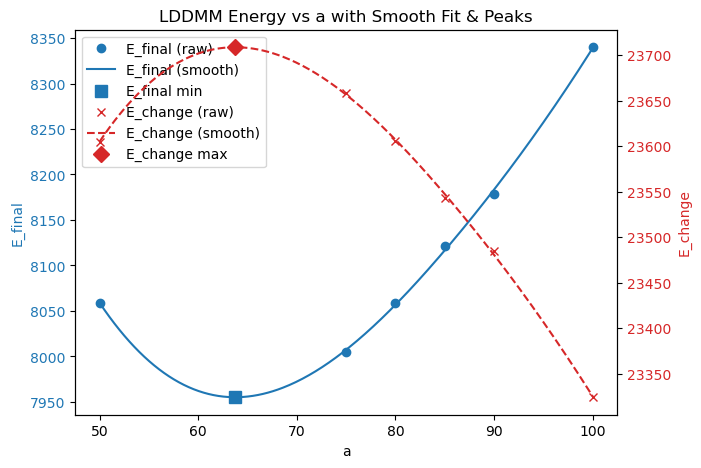

In [84]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline

# Your data
a_values = np.array([50, 75, 80, 85, 90, 100])
E_final = np.array([8059.049354, 8005.151043, 8058.439410, 8121.113673, 8178.826770, 8339.874019])
E_change = np.array([23604.851571, 23658.749883, 23605.461515, 23542.787253, 23485.074156, 23324.026906])

# Fit smooth splines
spline_Efinal = UnivariateSpline(a_values, E_final, s=50)
spline_Echange = UnivariateSpline(a_values, E_change, s=50)

# Fine points for smooth curve
a_fine = np.linspace(a_values.min(), a_values.max(), 300)
E_final_smooth = spline_Efinal(a_fine)
E_change_smooth = spline_Echange(a_fine)

# Find peak/min
a_peak_Efinal = a_fine[np.argmin(E_final_smooth)]
E_final_peak = np.min(E_final_smooth)

a_peak_Echange = a_fine[np.argmax(E_change_smooth)]
E_change_peak = np.max(E_change_smooth)

# Print peaks
print(f"Minimum E_final: {E_final_peak:.3f} at a = {a_peak_Efinal:.2f}")
print(f"Maximum E_change: {E_change_peak:.3f} at a = {a_peak_Echange:.2f}")

# Plotting
fig, ax1 = plt.subplots(figsize=(7,5))

# E_final
color1 = 'tab:blue'
ax1.set_xlabel('a')
ax1.set_ylabel('E_final', color=color1)
ax1.plot(a_values, E_final, 'o', color=color1, label='E_final (raw)')
ax1.plot(a_fine, E_final_smooth, '-', color=color1, label='E_final (smooth)')
ax1.plot(a_peak_Efinal, E_final_peak, 's', color=color1, markersize=8, label='E_final min')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_title('LDDMM Energy vs a with Smooth Fit & Peaks')

# E_change
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('E_change', color=color2)
ax2.plot(a_values, E_change, 'x', color=color2, label='E_change (raw)')
ax2.plot(a_fine, E_change_smooth, '--', color=color2, label='E_change (smooth)')
ax2.plot(a_peak_Echange, E_change_peak, 'D', color=color2, markersize=8, label='E_change max')
ax2.tick_params(axis='y', labelcolor=color2)

# Combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='best')

plt.show()

# Until here 

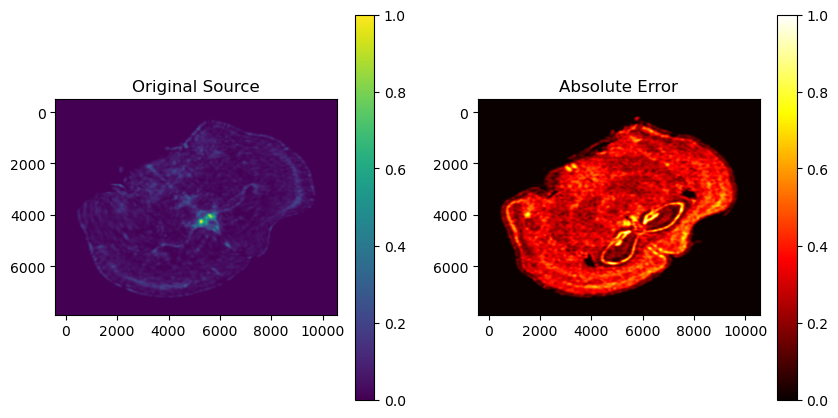

Mean Absolute Error: 0.13965554777728856


In [69]:
result = out_cell_g

# Get extent for plotting
extentI = STalignFunctions.extent_from_x((YI, XI))
extentJ = STalignFunctions.extent_from_x((YJ, XJ))


# Extract tensors
AI_plt = result['AI_plt']  # Moving/source image used for plotting
J_target = result['J']     # Target image
pointsIt = pointsI          # Optional landmarks

# If more than 3 channels, take mean across channels for visualization
if AI_plt.ndim == 3 and AI_plt.shape[0] > 3:
    AI_plot = torch.mean(AI_plt, dim=0)      # shape HxW
    J_plot = torch.mean(J_target, dim=0)
else:
    AI_plot = AI_plt[0]                       # first channel
    J_plot = J_target[0]

# Normalize AI_plot for display
baseline_norm = (AI_plot - torch.amin(AI_plot)) / (torch.amax(AI_plot) - torch.amin(AI_plot))

# Compute error w.r.t target
error = torch.abs(AI_plot - J_plot)
error_norm = (error - torch.amin(error)) / (torch.amax(error) - torch.amin(error))

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10,5))
im0 = ax[0].imshow(baseline_norm.detach().cpu(), extent=extentJ, cmap='viridis')
ax[0].set_title('Original Source')
im1 = ax[1].imshow(error_norm.detach().cpu(), extent=extentJ, cmap='hot')
ax[1].set_title('Absolute Error')

# Absolute error is the pixel-wise absolute error of the source relative to target 
plt.colorbar(im0, ax=ax[0])
plt.colorbar(im1, ax=ax[1])
plt.show()

# Quantify absolute error 
error = torch.abs(AI_plot - J_plot)

mae = torch.mean(error).item()
print("Mean Absolute Error:", mae)

In [38]:
A = out_cell_g['A']
v = out_cell_g['v']
xv = out_cell_g['xv']

In [39]:
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')

In [ ]:
## previous code block for ref:  (Dont run)
df10 = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_metadata_S2R2.csv', index_col=0)

df11 = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_by_gene_S2R2.csv',index_col=0)
#Load x position
x1 = np.array(df10['center_x']) #change to x positions of cells

#Load y position
y1 = np.array(df10['center_y']) #change to column y positions of cells


df20 = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv', index_col=0)


df21 = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_by_gene_S2R3.csv', index_col=0)

#Load x position
x2 = np.array(df20['center_x']) #change to x positions of cells

#Load y position
y2 = np.array(df20['center_y']) #change to column y positions of cells


In [42]:
#Xg1, Y, XI, YI = rasterizeByGene(x_1[0], x_1[1], G1, dx=15, blur=1.5, expand=1.2, draw=10000, wavelet_magnitude=False,use_windowing=True)
import STalignFunctions
# apply transform to original points
tpointsI= STalignFunctions.transform_points_source_to_target(xv,v,A, np.stack([y2, x2], 1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

#switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

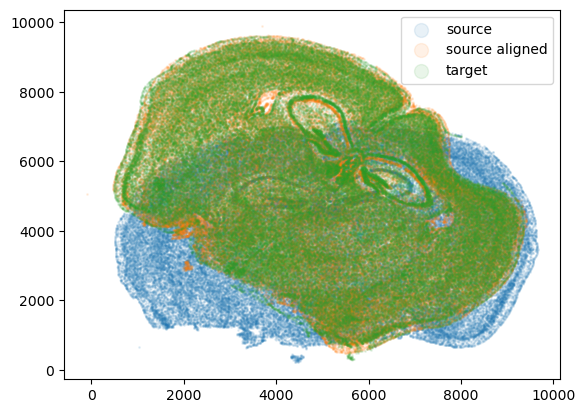

In [43]:
# plot results
fig,ax = plt.subplots()
ax.scatter(x2,y2,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(x1,y1,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)

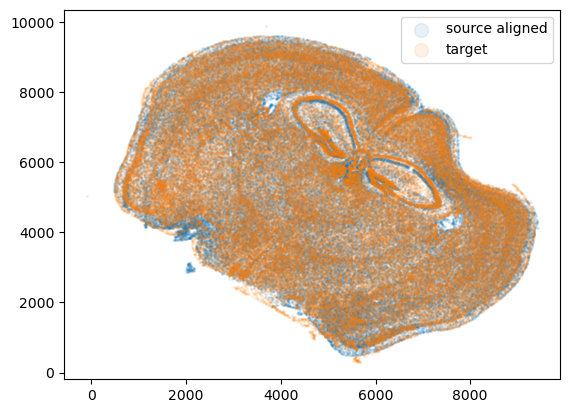

In [44]:
# plot results
fig,ax = plt.subplots()
#ax.scatter(x2,y2,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(x1,y1,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)

In [47]:
df3.shape, df20.shape

((85958, 2), (85958, 8))

In [50]:
# save the new aligned positions by appending to orig data 
df3 = pd.DataFrame(

    {

        "aligned_x": xI_LDDMM,

        "aligned_y": yI_LDDMM,

    },


)

results = pd.concat([df20, df3], axis=1)

In [54]:
results.head()

fov       volume    center_x  \
158338042824236264719696604356349910479  33.0   532.778772  617.916619   
260594727341160372355976405428092853003  33.0  1004.430016  596.808018   
307643940700812339199503248604719950662  33.0  1267.183208  578.880018   
30863303465976316429997331474071348973   33.0  1403.401822  572.616017   
313162718584097621688679244357302162401  33.0   507.949497  608.364018   

                                            center_y       min_x       max_x  \
158338042824236264719696604356349910479  2666.520010  614.725219  621.108019   
260594727341160372355976405428092853003  2763.450012  589.669218  603.946818   
307643940700812339199503248604719950662  2748.978012  570.877217  586.882818   
30863303465976316429997331474071348973   2766.690012  564.937217  580.294818   
313162718584097621688679244357302162401  2687.418010  603.061218  613.666818   

                                               min_y        max_y  aligned_x  \
158338042824236264719696604356349910479  2657.545209  2675.494810        NaN   
260594727341160372355976405428092853003  2757.013212  2769.886812        NaN   
307643940700812339199503248604719950662  2740.489211  2757.466812        NaN   
30863303465976316429997331474071348973   2756.581212  2776.798812        NaN   
313162718584097621688679244357302162401  2682.493210  2692.342810        NaN   

                                         aligned_y  
158338042824236264719696604356349910479        NaN  
260594727341160372355976405428092853003        NaN  
307643940700812339199503248604719950662        NaN  
30863303465976316429997331474071348973         NaN  
313162718584097621688679244357302162401        NaN

In [56]:
np.mean(results.center_x), np.mean(results.aligned_x)

(5144.959804234964, 5059.985441991936)

# try running with all cells not just selecting for genes 

/Users/iriskwon/miniforge3/envs/stalign-env/lib/python3.10/site-packages/torch/utils/_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_34417/3094894720.py:264: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[i].set_yscale('log')


CPU times: user 16min 59s, sys: 17min 30s, total: 34min 30s
Wall time: 15min 52s


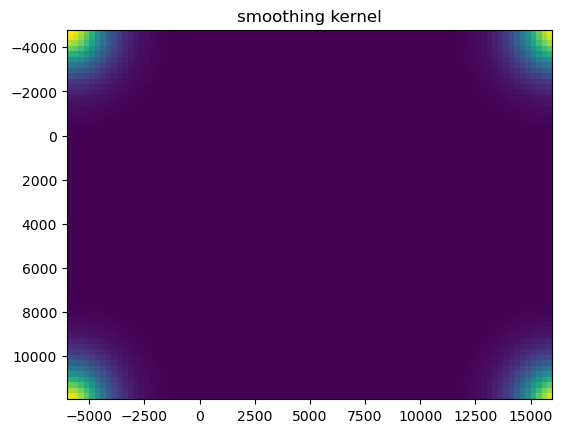

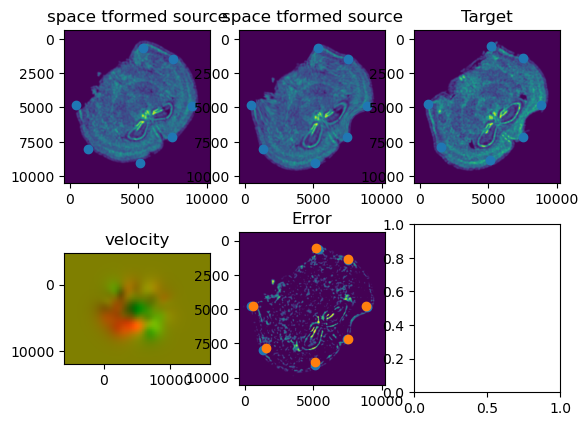

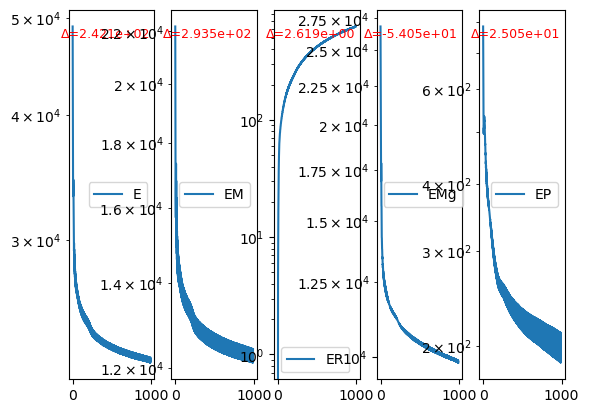

In [57]:
%%time
%matplotlib inline
# run LDDMM
# keep all other parameters default
params = {
            'niter': 1000,
            'a':500,
            'pointsI':pointsJ,
            'pointsJ':pointsI,
            'sigmaM': 0.25,
            'sigmaMg': 0.25,
             'A': A,
            #'epV': 2e,
            #'epV'
          }     

# selecting spatially distinct genes 
out_cell_g = LDDMM([YJ,XJ],Xg2,[YI,XI],Xg1, Xct2, Xct1,**params)

In [58]:
A = out_cell_g['A']
v = out_cell_g['v']
xv = out_cell_g['xv']

In [59]:
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')

In [60]:
#Xg1, Y, XI, YI = rasterizeByGene(x_1[0], x_1[1], G1, dx=15, blur=1.5, expand=1.2, draw=10000, wavelet_magnitude=False,use_windowing=True)

# apply transform to original points
tpointsI= STalignFunctions.transform_points_source_to_target(xv,v,A, np.stack([y2, x2], 1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

#switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

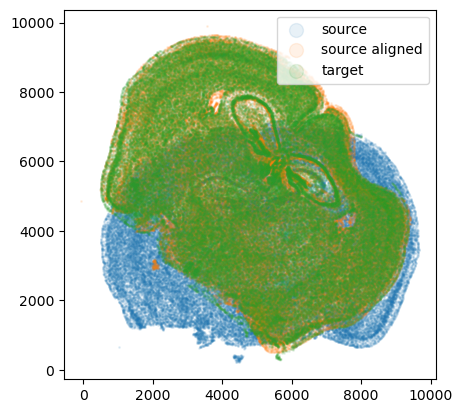

In [61]:
# plot results
fig,ax = plt.subplots()
ax.scatter(x2,y2,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(x1,y1,s=1,alpha=0.1, label='target')
ax.set_aspect('equal')

ax.legend(markerscale = 10)

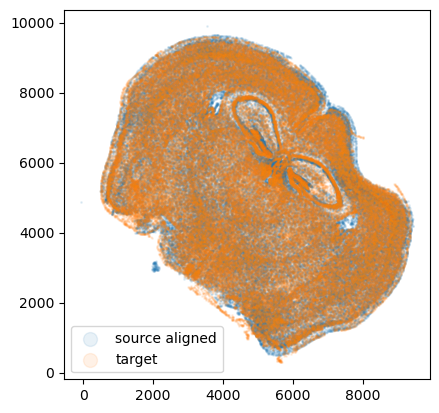

In [64]:
# plot results
fig,ax = plt.subplots()
#ax.scatter(x2,y2,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(x1,y1,s=1,alpha=0.1, label='target')
ax.set_aspect('equal')

ax.legend(markerscale = 10)

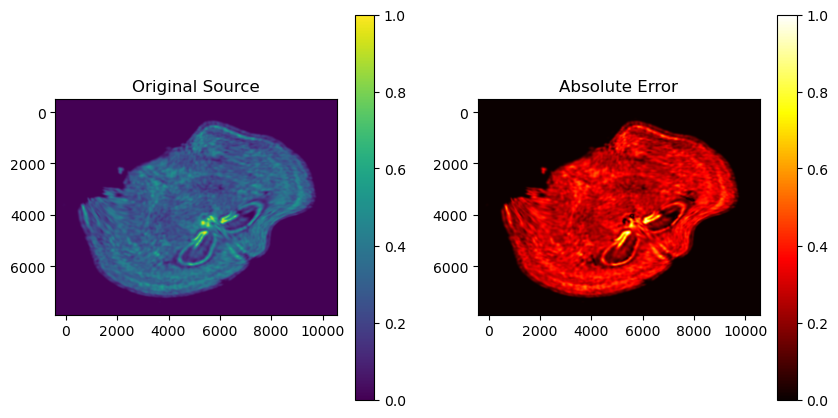

Mean Absolute Error: 0.12561613363175536


In [67]:
result = out_cell_g

# Get extent for plotting
extentI = STalignFunctions.extent_from_x((YI, XI))
extentJ = STalignFunctions.extent_from_x((YJ, XJ))


# Extract tensors
AI_plt = result['AI_plt']  # Moving/source image used for plotting
J_target = result['J']     # Target image
pointsIt = pointsI          # Optional landmarks

# If more than 3 channels, take mean across channels for visualization
if AI_plt.ndim == 3 and AI_plt.shape[0] > 3:
    AI_plot = torch.mean(AI_plt, dim=0)      # shape HxW
    J_plot = torch.mean(J_target, dim=0)
else:
    AI_plot = AI_plt[0]                       # first channel
    J_plot = J_target[0]

# Normalize AI_plot for display
baseline_norm = (AI_plot - torch.amin(AI_plot)) / (torch.amax(AI_plot) - torch.amin(AI_plot))

# Compute error w.r.t target
error = torch.abs(AI_plot - J_plot)
error_norm = (error - torch.amin(error)) / (torch.amax(error) - torch.amin(error))

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10,5))
im0 = ax[0].imshow(baseline_norm.detach().cpu(), extent=extentJ, cmap='viridis')
ax[0].set_title('Original Source')
im1 = ax[1].imshow(error_norm.detach().cpu(), extent=extentJ, cmap='hot')
ax[1].set_title('Absolute Error')

# Absolute error is the pixel-wise absolute error of the source relative to target 
plt.colorbar(im0, ax=ax[0])
plt.colorbar(im1, ax=ax[1])
plt.show()

# Quantify absolute error 
error = torch.abs(AI_plot - J_plot)

mae = torch.mean(error).item()
print("Mean Absolute Error:", mae)

In [ ]:
# save the new aligned positions by appending to orig data 
df3 = pd.DataFrame(

    {

        "aligned_x": xI_LDDMM,

        "aligned_y": yI_LDDMM,

    },


)

results = pd.concat([df20, df3], axis=1)
results

# Until here

In [ ]:
import STalignFunctions

#out_cell_g = LDDMM([YJ,XJ],Xg2[[22,33,40,42,48],:,:],[YI,XI],Xg1[[22,33,40,42,48],:,:], Xct2, Xct1,**params)

# Extract rasterized images
I = out_cell_g['AI_plt']  # moving/source image
J = out_cell_g['J']       # target image

# Get extent for plotting
extentI = STalignFunctions.extent_from_x((YI, XI))
extentJ = STalignFunctions.extent_from_x((YJ, XJ))

# If the images have multiple channels (like 5), choose a representative channel or mean
if I.ndim == 3 and I.shape[0] > 3:  # more than 3 channels
    I_plot = torch.mean(I, dim=0)  # shape (H,W)
    J_plot = torch.mean(J, dim=0)
else:
    I_plot = I[0]  # first channel
    J_plot = J[0]

# Plot
fig, ax = plt.subplots(1,2, figsize=(10,5))
im0 = ax[0].imshow(I_plot.detach().cpu(), extent=extentI, cmap='viridis')
im1 = ax[1].imshow(J_plot.detach().cpu(), extent=extentJ, cmap='viridis')
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_title("Rasterized Source Image, I")
ax[1].set_title("Rasterized Target Image, J")
plt.colorbar(im0, ax=ax[0])
plt.colorbar(im1, ax=ax[1])
plt.show()


In [ ]:
result = out_cell_g

# Extract tensors
AI_plt = result['AI_plt']  # Moving/source image used for plotting
J_target = result['J']     # Target image
pointsIt = pointsI          # Optional landmarks

# If more than 3 channels, take mean across channels for visualization
if AI_plt.ndim == 3 and AI_plt.shape[0] > 3:
    AI_plot = torch.mean(AI_plt, dim=0)      # shape HxW
    J_plot = torch.mean(J_target, dim=0)
else:
    AI_plot = AI_plt[0]                       # first channel
    J_plot = J_target[0]

# Normalize AI_plot for display
baseline_norm = (AI_plot - torch.amin(AI_plot)) / (torch.amax(AI_plot) - torch.amin(AI_plot))

# Compute error w.r.t target
error = torch.abs(AI_plot - J_plot)
error_norm = (error - torch.amin(error)) / (torch.amax(error) - torch.amin(error))

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10,5))
im0 = ax[0].imshow(baseline_norm.detach().cpu(), extent=extentJ, cmap='viridis')
ax[0].set_title('Original Source')
im1 = ax[1].imshow(error_norm.detach().cpu(), extent=extentJ, cmap='hot')
ax[1].set_title('Absolute Error')

# Absolute error is the pixel-wise absolute error of the source relative to target 
plt.colorbar(im0, ax=ax[0])
plt.colorbar(im1, ax=ax[1])
plt.show()

In [ ]:
# Quantify absolute error 
error = torch.abs(AI_plot - J_plot)

mae = torch.mean(error).item()
print("Mean Absolute Error:", mae)

# Still need to edit LDDMM_mod
- Make it optional to include gene exp

### Run with gene expression for spatially distinct genes:

In [ ]:
%%time
%matplotlib inline
# run LDDMM
# keep all other parameters default
params = {
            'niter': 1000,
            'a':500,
            'pointsI':pointsJ,
            'pointsJ':pointsI,
            'sigmaM': 0.25,
            'sigmaMg': 0.25,
             'A': A,
            #'epV': 2e,
            #'epV'
          }     

# selecting spatially distinct genes 
out_cell_g = LDDMM_mod(
    [YJ,XJ], # source positions for image I 
    Xg2[[22,33,40,42,48],:,:], # gene expression 
    [YI,XI], # target positions for image J 
    Xg1[[22,33,40,42,48],:,:], # gene expression  
    Xct2, Xct1, # gene maps 
    **params)

### Run without gene expression 

In [ ]:
%%time
%matplotlib inline
# run LDDMM
# keep all other parameters default
params = {
            'niter': 1000,
            'a':500,
            'pointsI':pointsJ,
            'pointsJ':pointsI,
            'sigmaM': 0.25,
            'sigmaMg': 0.25,
             'A': A,
            #'epV': 2e,
            #'epV'
          }     

# selecting spatially distinct genes 
out_cell_g = LDDMM_mod(
    [YJ,XJ], # source positions for image I 
    Xg2[[22,33,40,42,48],:,:], # gene expression  (I)
    [YI,XI], # target positions for image J 
    Xg1[[22,33,40,42,48],:,:], # gene expression  (J)
    # Xct2, Xct1, # gene maps (Ig, Jg)
    **params)

In [ ]:
out = out_cell_g

# get necessary output variables
A = out['A']
v = out['v']
xv = out['xv']

In [ ]:
from STalign import STalign 
dir(STalign)

In [ ]:
# apply transform
phii = STalign.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = STalign.transform_image_source_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])

#switch tensor from cuda to cpu for plotting with numpy
if phii.is_cuda:
    phii = phii.cpu()
if phiI.is_cuda:
    phiI = phiI.cpu()

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')
ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.invert_yaxis()

In [ ]:
def LDDMM_mod(xI, I, xJ, J, Ig=None, Jg=None, pointsI=None, pointsJ=None,
              L=None, T=None, A=None, v=None, xv=None,
              a=500.0, p=2.0, expand=2.0, nt=3,
              niter=5000, diffeo_start=0, epL=2e-8, epT=2e-1, epV=2e3,
              sigmaM=1.0, sigmaMg=1.0, sigmaB=2.0, sigmaA=5.0, sigmaR=5e5, sigmaP=2e1,
              device='cpu', dtype=torch.float64, muB=None, muA=None):

    # -----------------------------
    # Affine initialization
    # -----------------------------
    if A is not None:
        if L is not None or T is not None:
            raise Exception('If specifying A, do not specify L or T')
        L = A[:2,:2].clone().detach().to(device=device, dtype=dtype).requires_grad_(True)
        T = A[:2,-1].clone().detach().to(device=device, dtype=dtype).requires_grad_(True)
    else:
        if L is None:
            L = to rch.eye(2, device=device, dtype=dtype, requires_grad=True)
        else:
            L = L.clone().detach().to(device=device, dtype=dtype).requires_grad_(True)
        if T is None:
            T = torch.zeros(2, device=device, dtype=dtype, requires_grad=True)
        else:
            T = T.clone().detach().to(device=device, dtype=dtype).requires_grad_(True)

    # -----------------------------
    # Convert inputs to torch tensors
    # -----------------------------
    I = torch.tensor(I, device=device, dtype=dtype)
    J = torch.tensor(J, device=device, dtype=dtype)
    if Ig is not None and Jg is not None:
        Ig = torch.tensor(Ig, device=device, dtype=dtype)
        Jg = torch.tensor(Jg, device=device, dtype=dtype)

    # -----------------------------
    # Velocity field initialization
    # -----------------------------
    if v is not None and xv is not None:
        v = torch.tensor(v, device=device, dtype=dtype, requires_grad=True)
        xv = [torch.tensor(x, device=device, dtype=dtype) for x in xv]
        XV = torch.stack(torch.meshgrid(xv), -1)
        nt = v.shape[0]
    elif v is None and xv is None:
        minv = torch.as_tensor([x[0] for x in xI], device=device, dtype=dtype)
        maxv = torch.as_tensor([x[-1] for x in xI], device=device, dtype=dtype)
        minv, maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0], device=device, dtype=dtype)[...,None]*(maxv-minv)*expand
        xv = [torch.arange(m,M,a*0.5, device=device, dtype=dtype) for m,M in zip(minv,maxv)]
        XV = torch.stack(torch.meshgrid(xv), -1)
        v = torch.zeros((nt, XV.shape[0], XV.shape[1], XV.shape[2]), device=device, dtype=dtype, requires_grad=True)
    else:
        raise Exception("If inputting initial v, must provide both xv and v")

    extentV = extent_from_x(xv)
    dv = torch.as_tensor([x[1]-x[0] for x in xv], device=device, dtype=dtype)

    # -----------------------------
    # Smoothing kernel
    # -----------------------------
    fv = [torch.arange(n, device=device, dtype=dtype)/n/d for n,d in zip(XV.shape,dv)]
    FV = torch.stack(torch.meshgrid(fv),-1)
    LL = (1.0 + 2.0*a**2* torch.sum((1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0)
    K = 1.0/LL
    DV = torch.prod(dv)
    Ki = torch.fft.ifftn(K).real

    # -----------------------------
    # Point/weight initialization
    # -----------------------------
    WM = torch.ones(J[0].shape, dtype=J.dtype, device=J.device)*0.5
    WB = torch.ones(J[0].shape, dtype=J.dtype, device=J.device)*0.4
    WA = torch.ones(J[0].shape, dtype=J.dtype, device=J.device)*0.1
    if pointsI is None and pointsJ is None:
        pointsI = torch.zeros((0,2), device=J.device, dtype=J.dtype)
        pointsJ = torch.zeros((0,2), device=J.device, dtype=J.dtype)
    elif (pointsI is None) != (pointsJ is None):
        raise Exception("Must specify corresponding points or none at all")
    else:
        pointsI = torch.tensor(pointsI, device=J.device, dtype=J.dtype)
        pointsJ = torch.tensor(pointsJ, device=J.device, dtype=J.dtype)

    xI = [torch.tensor(x, device=device, dtype=dtype) for x in xI]
    xJ = [torch.tensor(x, device=device, dtype=dtype) for x in xJ]
    XI = torch.stack(torch.meshgrid(*xI, indexing='ij'), -1)
    XJ = torch.stack(torch.meshgrid(*xJ, indexing='ij'), -1)
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = (xJ[1][0].item()-dJ[1]/2.0, xJ[1][-1].item()+dJ[1]/2.0,
               xJ[0][-1].item()+dJ[0]/2.0, xJ[0][0].item()-dJ[0]/2.0)

    estimate_muA = muA is None
    estimate_muB = muB is None

    fig, ax = plt.subplots(2,3)
    ax = ax.ravel()
    figE, axE = plt.subplots(1,5)
    Esave = []

    try: L.grad.zero_()
    except: pass
    try: T.grad.zero_()
    except: pass

    # -----------------------------
    # Main iteration loop
    # -----------------------------
    for it in range(niter):
        A = to_A(L,T)
        Ai = torch.linalg.inv(A)

        # Transform points
        Xs = (Ai[:2,:2]@XJ[...,None])[...,0] + Ai[:2,-1]
        for t in range(nt-1,-1,-1):
            Xs = Xs + interp(xv, -v[t].permute(2,0,1), Xs.permute(2,0,1)).permute(1,2,0)/nt

        pointsIt = pointsI.clone()
        if pointsIt.shape[0]>0:
            for t in range(nt):
                pointsIt += interp(xv, v[t].permute(2,0,1), pointsIt.T[...,None])[...,0].T/nt
            pointsIt = (A[:2,:2]@pointsIt.T + A[:2,-1][...,None]).T

        # Transform images
        AI = interp(xI, I, Xs.permute(2,0,1), padding_mode="border")
        if Ig is not None:
            AIg = interp(xI, Ig, Xs.permute(2,0,1), padding_mode="border")
            if it==0: AI_orig = AIg.clone()

        # Compute energies
        EM = torch.sum((AI - J)**2 * WM)/2.0/sigmaM**2
        ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
        E = EM + ER
        tosave = [EM.item(), ER.item()]

        if Ig is not None and Jg is not None:
            EMg = torch.sum((AIg - Jg)**2 * WM)/2.0/sigmaMg**2
            E += EMg
            tosave.insert(1, EMg.item())

        if pointsIt.shape[0]>0:
            EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
            E += EP
            tosave.append(EP.item())

        Esave.append(tosave)

        # -----------------------------
        # Gradient update
        # -----------------------------
        E.backward()
        with torch.no_grad():
            L -= (epL/(1.0 + (it>=diffeo_start)*9))*L.grad
            T -= (epT/(1.0 + (it>=diffeo_start)*9))*T.grad
            L.grad.zero_()
            T.grad.zero_()

            vgrad = torch.fft.ifftn(torch.fft.fftn(v.grad,dim=(1,2))*K[...,None],dim=(1,2)).real
            if it >= diffeo_start:
                v -= epV * vgrad
            v.grad.zero_()

            if estimate_muA:
                muA = torch.sum(WA*J, dim=(-1,-2))/torch.sum(WA)
            if estimate_muB:
                muB = torch.sum(WB*J, dim=(-1,-2))/torch.sum(WB)
    # -----------------------------
    # Plot every 10 iterations
    # -----------------------------
    if not it % 10:
        # Prepare averaged plots if gene maps are provided
        if Ig is not None and Jg is not None:
            AI_plt = torch.mean(AIg, 0, keepdim=True)
            AI_orig_plt = torch.mean(AI_orig, 0, keepdim=True)
            J_plt = torch.mean(Jg, 0, keepdim=True)
        else:
            AI_plt = AI
            AI_orig_plt = AI_orig
            J_plt = J

    # -----------------------------
    # Spatial plots
    # -----------------------------
    # Original baseline
    ax[0].cla()
    baseline_norm = (AI_orig_plt - torch.amin(AI_orig_plt, (1,2), keepdim=True)) / \
                    (torch.amax(AI_orig_plt, (1,2), keepdim=True) - torch.amin(AI_orig_plt, (1,2), keepdim=True))
    ax[0].imshow(baseline_norm.permute(1,2,0).detach().cpu(), extent=extentJ)
    ax[0].scatter(pointsIt[:,1].detach().cpu(), pointsIt[:,0].detach().cpu(), c='r', s=10)
    ax[0].set_title('Original source (baseline)')

    # Current source after updates
    ax[1].cla()
    current_norm = (AI_plt - torch.amin(AI_plt, (1,2), keepdim=True)) / \
                   (torch.amax(AI_plt, (1,2), keepdim=True) - torch.amin(AI_plt, (1,2), keepdim=True))
    ax[1].imshow(current_norm.permute(1,2,0).detach().cpu(), extent=extentJ)
    ax[1].scatter(pointsIt[:,1].detach().cpu(), pointsIt[:,0].detach().cpu(), c='r', s=10)
    ax[1].set_title('Current transformed source')

    # Target
    ax[2].cla()
    ax[2].imshow(J_plt.permute(1,2,0).detach().cpu() / torch.max(J_plt).item(), extent=extentJ)
    ax[2].scatter(pointsJ[:,1].detach().cpu(), pointsJ[:,0].detach().cpu(), c='b', s=10)
    ax[2].set_title('Target')

    # Velocity field
    ax[3].cla()
    toshow = v[0].clone().detach().cpu()
    toshow /= torch.max(torch.abs(toshow))
    toshow = toshow*0.5 + 0.5
    toshow = torch.cat((toshow, torch.zeros_like(toshow[...,0][...,None])), -1)
    ax[3].imshow(clip(toshow), extent=extentV)
    ax[3].set_title('Velocity field')

    # Error map
    ax[4].cla()
    error_map = clip((AI_plt - J_plt)/torch.max(J_plt).item()*3.0).permute(1,2,0).detach().cpu()*0.5 + 0.5
    ax[4].imshow(error_map, extent=extentJ)
    ax[4].scatter(pointsIt[:,1].detach().cpu(), pointsIt[:,0].detach().cpu(), c='r', s=10)
    ax[4].scatter(pointsJ[:,1].detach().cpu(), pointsJ[:,0].detach().cpu(), c='b', s=10)
    ax[4].set_title('Error (current - target)')

    # -----------------------------
    # Energy plot (components + total)
    # -----------------------------
    axE[0].cla()
    labels = ['EM', 'EMg', 'ER', 'EP'] if (Ig is not None and Jg is not None) else ['EM', 'ER', 'EP']
    for i, lbl in enumerate(labels):
        axE[0].plot([e[i] for e in Esave], label=lbl)
    # Total energy
    E_total = [sum(e) for e in Esave]
    axE[0].plot(E_total, 'k--', label='E_total', linewidth=1.5)
    axE[0].legend()
    axE[0].set_yscale('log')
    axE[0].set_title('Energy (components + total)')
    axE[0].text(0.02, 0.95, f'Total ΔE: {E_total[0]-E_total[-1]:.3e}', transform=axE[0].transAxes,
                 fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    # Redraw figures
    fig.canvas.draw()
    figE.canvas.draw()
    # -----------------------------
    # Return final results
    # -----------------------------
    return {
        'A': A.clone().detach(),
        'v': v.clone().detach(),
        'xv': xv,
        'WM': WM.clone().detach(),
        'WB': WB.clone().detach(),
        'WA': WA.clone().detach(),
        "AI_plt": AI_plt.clone().detach(),
        "AI": AI.clone().detach(),
        "J": J.clone().detach()
    }